In [2]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy import units as u
from astropy import constants as const
from astropy.wcs import WCS
from scipy import ndimage
import radio_beam
from spectral_cube import SpectralCube
from reproject import reproject_exact
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
from time import localtime, strftime#, time
#import os.path
#import glob
#from pyBBarolo.wrapper import BBaroloWrapper

In [3]:
califaoutpath = '/vol/aibn1081/data1/brodriguez/CALIFA/'
acaoutpath    = '/vol/aibn1081/data1/brodriguez/ACA/'
califainpath  = '/vol/alcina/data1/shared/EDGE/PIPE3DS_v2.3/'
acainpath     = '/vol/alcina/data1/shared/EDGE/aca_edge_natv/cubes/'

In [17]:
#califapattern = os.path.join(califainpath,"*.Pipe3D.cube.fits.gz")
#acapattern = os.path.join(acainpath,"*_7m_co21_pbcor.fits")
#print("CALIFA input pattern:",califapattern)
#print("ACA input pattern:",acapattern)
#califafilepaths = sorted(glob.glob(califapattern))
#acafilepaths = sorted(glob.glob(acapattern))

In [4]:
califa_sources = np.array([filename.replace('.Pipe3D.cube.fits.gz','').replace(califainpath,'') for filename in califafilepaths])
aca_sources = np.array([filename.replace('_7m_co21_pbcor.fits','').replace(acainpath,'') for filename in acafilepaths])
sources = aca_sources[np.isin(aca_sources,califa_sources)]

In [5]:
print ("Number of CALIFA files found : ",len(califafilepaths))
print ("Number of ACA cubes found : ",len(acafilepaths))
print ("Number of overlapping sources : ",len(sources))

Number of CALIFA files found :  895
Number of ACA cubes found :  60
Number of overlapping sources :  55


In [4]:
aca_table = pd.read_csv('/users/brodriguez/Documents/ACA_sourcelist.csv',sep=',',index_col=0)

In [5]:
aca_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, CGCG429-012 to VV488NED02
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   califa_file         60 non-null     object 
 1   Final_QS            60 non-null     object 
 2   Final_NA            60 non-null     object 
 3   RA                  60 non-null     float64
 4   DEC                 60 non-null     float64
 5   inclination_ACA     60 non-null     int64  
 6   PA_ACA              60 non-null     int64  
 7   z_ACA               60 non-null     float64
 8   Dist_Mpc_ACA        60 non-null     int64  
 9   Re_arc_ACA          60 non-null     float64
 10  z_stars             60 non-null     float64
 11  inclination_califa  60 non-null     float64
 12  PA_califa           60 non-null     float64
 13  Re_arc_califa       60 non-null     float64
 14  Re_kpc_califa       60 non-null     float64
 15  log_Mass            60 non-null     float64
 1

In [6]:
sources = aca_table[aca_table['califa_file']!='---'].index.to_numpy()

In [7]:
aca_table = aca_table.loc[sources]

In [8]:
print(len(aca_table))

58


In [8]:
n = 0
for source in sources:
    hdu_list = fits.open(califainpath+source+'.Pipe3D.cube.fits.gz')
    n+=1
    hdu_list.close()
print(n)

55


In [16]:
hdu_list = fits.open(califainpath+'UGC12250'+'.Pipe3D.cube.fits.gz')

In [20]:
WCS(hdu_list[0].header).to_header()

WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                 69.0 / Pixel coordinate of reference point            
CRPIX2  =                 63.0 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
PC1_1   = -0.00013888888888888 / Coordinate transformation matrix element       
PC2_2   =  0.00013888888888889 / Coordinate transformation matrix element       
PC3_3   =                  2.0 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT3  =                  1.0 / [Angstrom] Coordinate increment at reference po
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CUNIT3  = 'Angstrom'        

outputpath = '/vol/aibn1081/data1/brodriguez/'
califapath = '/vol/alcina/data1/shared/EDGE/PIPE3DS_v2.3/'
acapath = '/vol/alcina/data1/shared/EDGE/aca_edge_natv/cubes/'

path = '/vol/aibn1081/data1/brodriguez/'
source = 'UGC12250'
cube_path = path+source+'_7m_co21_pbcor.fits'
reduced_path = cube_path.replace('pbcor','reduced')
mask_path = cube_path.replace('pbcor','smoothmask')
integrated_path = cube_path.replace('pbcor','integrated')

In [9]:
from astropy.cosmology import LambdaCDM#, FlatLambdaCDM
cosmo = LambdaCDM(H0=69.7,Om0=0.3,Ode0=0.7)

In [10]:
def get_data(filename,header=False):
    hdu_list = fits.open(filename)
    data = hdu_list[0].data
    hdr = hdu_list[0].header
    hdu_list.close()
    if header:
        return data, hdr
    else:
        return data

In [11]:
def deproject(ra, dec, galpos, vector = False,
              gal=None):

    np.seterr(divide='ignore', invalid='ignore')
    #print(ra.shape,dec.shape)

    if not gal is None:
        pa = np.deg2rad(gal["posang_deg"])
        inc = np.deg2rad(gal["incl_def"])
        xctr = gal["ra_deg"]
        yctr = gal["dec_deg"]
    elif len(galpos) == 5:
        vlsr = galpos[0]
        pa   = np.deg2rad(galpos[1])
        inc  = np.deg2rad(galpos[2])
        xctr = galpos[3]
        yctr = galpos[4]

    else:
        pa   = np.deg2rad(galpos[0])
        inc  = np.deg2rad(galpos[1])
        xctr = galpos[2]
        yctr = galpos[3]

    ra_size = np.shape(ra)
    dec_size = np.shape(dec)

    if ra_size[0]==1 and vector==False:
        # IF THE USER HAS SUPPLIED ARRAYS AND NOT IMAGES THEN MAKE 2-D GRID,
        # ONE CONTAINING RA AND ONE CONTAINING DEC
        rimg = np.outer(ra, np.ones(len(dec)))
        dimg = np.outer(np.ones(len(ra)), dec)
    else:
        rimg = ra
        dimg = dec

    # RECAST THE RA AND DEC ARRAYS IN TERMS OF THE CENTERS
    # ARRAYS ARE NOW IN DEGREES FROM CENTER
    xgrid = (rimg - xctr)*np.cos(np.deg2rad(yctr))
    ygrid = (dimg - yctr)
    # ROTATION ANGLE (ROTATE YOUR X-AXIS UP TO THE MAJOR AXIS)
    rotang =  (-1.*(pa - 1.0*np.pi/2.))
    # MAKE 2-D GRIDS FOR ROTATED X AND Y
    deproj_x = xgrid * np.cos(rotang) + ygrid * np.sin(rotang)
    deproj_y = ygrid * np.cos(rotang) - xgrid * np.sin(rotang)
    # REMOVE INCLINATION EFFECT
    deproj_y = deproj_y / np.cos((inc))
    # MAKE GRID OF DEPROJECTED DISTANCE FROM THE CENTER
    rgrid = np.sqrt(deproj_x**2 + deproj_y**2)
    #print(rgrid.shape)
    # MAKE GRID OF ANGLE W.R.T. PA
    tgrid = np.arctan2(deproj_y, deproj_x)

    return rgrid, tgrid

In [12]:
G = const.G.to(u.kpc**3/(u.Msun*u.s**2)).value # gravitational constant
k_B = (const.k_B).to(u.Msun*u.kpc**2/u.s**2/u.K).value # Boltzmann constant
S_H1 = 7.*10**6 # average atomic gas mass surface density in M_sun kpc^-2
Z_sun = 4.9*10**-4 # solar metallicity, Baumgartner & Mushotzky 2006
alphaCO_MW = 4.3 # M_sun/(K km s^-1 pc^2) from Milky Way observations

In [13]:
import warnings
from spectral_cube.utils import SpectralCubeWarning
warnings.filterwarnings(action='ignore', category=SpectralCubeWarning,append=True)

In [312]:
scale1_sources = []
scale125_sources = []
scale15_sources = []
for source in sources[:]:
    CO_int, aca_hdr = get_data(acaoutpath+source+'_integrated.fits',header=True)
    pix_scale_aca = aca_hdr['CDELT2']*3600 # spaxel size in arcsec
    
    #M_star, califa_hdr = get_data(califaoutpath+source+'_Mstar.fits',header=True)
    #pix_scale_califa = califa_hdr['PC2_2']*3600 # pixel size in arcsec
    if (abs(pix_scale_aca-1.5)<0.01):
        scale15_sources.append(source)
    elif (abs(pix_scale_aca-1.25)<0.01):
        scale125_sources.append(source)
    elif (abs(pix_scale_aca-1.)<0.01):
        scale1_sources.append(source)

In [314]:
print(scale1_sources)
print(scale15_sources)
print(scale125_sources)

['IC1528', 'MCG-01-01-012', 'MCG-02-02-030', 'NGC2449', 'NGC3300', 'NGC7364', 'UGC01368', 'UGC04240', 'UGC04455', 'UGC05396', 'UGC11680NED02', 'UGC11982', 'VV488NED02']
['CGCG429-012', 'IC1079', 'MCG-01-10-015', 'MCG-01-52-012', 'MCG-02-51-004', 'NGC0001', 'NGC0155', 'NGC0169', 'NGC0171', 'NGC0180', 'NGC0693', 'NGC0731', 'NGC0768', 'NGC0955', 'NGC1056', 'NGC1542', 'NGC2540', 'NGC6427', 'NGC7194', 'NGC7311', 'NGC7321', 'NGC7466', 'NGC7489', 'UGC00312', 'UGC00335NED02', 'UGC01123', 'UGC01938', 'UGC02099', 'UGC04245', 'UGC08322', 'UGC08781', 'UGC10972', 'UGC11649', 'UGC11958', 'UGC12224', 'UGC12250', 'UGC12274']
['IC2341', 'NGC2554', 'NGC2595', 'NGC7025', 'NGC7625', 'NGC7716', 'UGC11792', 'UGC12348']


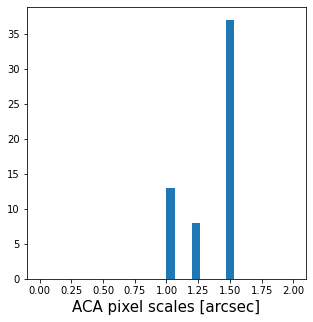

In [294]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(aca_scales,bins=np.linspace(0,2,31))
ax.set_xlabel(r'ACA pixel scales [arcsec]',size=15)
plt.show()

In [304]:
for source in sources[:]:
    #print('\nInitializing source',source)
    #M_star, califa_hdr = get_data(califaoutpath+source+'_Mstar.fits',header=True)    
    Ha_mask = get_data(califaoutpath+source+'_Ha_mask.fits')
    F_Ha = get_data(califaoutpath+source+'_F_Ha.fits')
    eF_Ha = get_data(califaoutpath+source+'_eF_Ha.fits')
    if (F_Ha[Ha_mask]/eF_Ha[Ha_mask]<3).any():
    #if (F_Ha/eF_Ha<1).any():
        print('Source:',source)

In [328]:
scales = []
areas = []
for source in sources[:]:
    #print('\nInitializing source',source)
    z = aca_table.loc[source,'z_stars']
    inc = aca_table.loc[source,'inclination_califa']
    cos = np.cos(np.deg2rad(inc))
    D_lum = cosmo.luminosity_distance(z)
    D_ang = cosmo.angular_diameter_distance(z)

    CO_int, aca_hdr = get_data(acaoutpath+source+'_integrated.fits',header=True)
    pix_scale_aca = (np.deg2rad(aca_hdr['CDELT2'])*D_ang).to(u.kpc).value
    pix_area_aca = ((np.deg2rad(aca_hdr['CDELT2'])*D_ang)**2).to(u.kpc**2).value/cos
    #M_star, califa_hdr = get_data(califaoutpath+source+'_Mstar.fits',header=True)
    #pix_scale_califa = califa_hdr['PC2_2']*3600 # pixel size in arcsec
    #pix_area_califa = ((np.deg2rad(califa_hdr['PC2_2'])*D_ang)**2).to(u.kpc**2)
    
    scales.append(pix_scale_aca)
    areas.append(pix_area_aca)
areas = np.array(areas)
scales = np.array(scales)

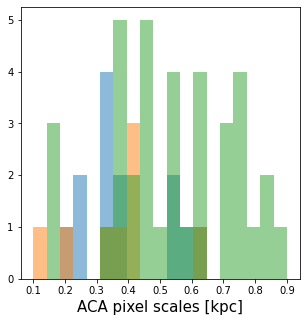

In [326]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(scales[np.isin(sources,scale1_sources)],alpha=0.5,bins=np.linspace(0.1,0.9,20))
ax.hist(scales[np.isin(sources,scale125_sources)],alpha=0.5,bins=np.linspace(0.1,0.9,20))
ax.hist(scales[np.isin(sources,scale15_sources)],alpha=0.5,bins=np.linspace(0.1,0.9,20))
ax.set_xlabel(r'ACA pixel scales [kpc]',size=15)
plt.show()

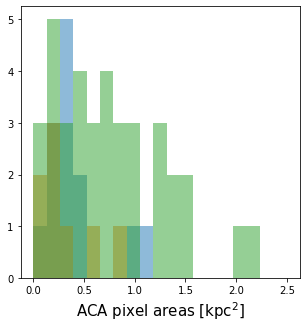

In [331]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(areas[np.isin(sources,scale1_sources)],alpha=0.5,bins=np.linspace(0.,2.5,20))
ax.hist(areas[np.isin(sources,scale125_sources)],alpha=0.5,bins=np.linspace(0.,2.5,20))
ax.hist(areas[np.isin(sources,scale15_sources)],alpha=0.5,bins=np.linspace(0.,2.5,20))
ax.set_xlabel(r'ACA pixel areas [kpc$^2$]',size=15)
plt.show()

In [21]:
D4000_Data = []
for source in sources[:]:
    print('\nInitializing source',source)
    z = aca_table.loc[source,'z_stars']
    inc = aca_table.loc[source,'inclination_califa']
    cos = np.cos(np.deg2rad(inc))
    PA = aca_table.loc[source,'PA_califa']-90 # Position angle in degrees
    Re = aca_table.loc[source,'Re_arc_califa'] # Effective radius in arcsec
    D_lum = cosmo.luminosity_distance(z)
    D_ang = cosmo.angular_diameter_distance(z)
    #Re = np.deg2rad(Re/3600)*D_ang.to(u.kpc).value # Effective radius in kpc
    #hs = Re/(1.68*7.3) # disc scale height in kpc
    #QS = aca_table.loc[source,'Final_QS']
    #NA = aca_table.loc[source,'Final_NA']
    
    # Deprojecting inclination effects
    #reduced_cube = SpectralCube.read(acaoutpath+source+'_reduced.fits')
    #mom0 = reduced_cube.moment(order=0)
    #dec, ra = mom0.world[:]
    #ra = ra.value
    #dec = dec.value
    #rgrid, tgrid = deproject(ra, dec, [PA,inc,aca_table.loc[source,'RA'],aca_table.loc[source,'DEC']])
    #rgrid = np.deg2rad(rgrid)*D_ang.to(u.kpc)
    
    Mstar, califa_hdr = get_data(califaoutpath+source+'_Mstar.fits',header=True)
    pix_scale_califa = califa_hdr['PC2_2']*3600 # pixel size in arcsec
    pix_area_califa = ((np.deg2rad(califa_hdr['PC2_2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of CALIFA pixel: {pix_scale_califa:.2} arcsec')
    #print(f'Surface area per CALIFA pixel: {pix_area_califa:.6}\n')
    
    Ha_mask = get_data(califaoutpath+source+'_Ha_mask.fits')
    F_NII = get_data(califaoutpath+source+'_F_NII.fits')
    F_OIII = get_data(califaoutpath+source+'_F_OIII.fits')
    F_Ha = get_data(califaoutpath+source+'_F_Ha.fits')
    F_Hb = get_data(califaoutpath+source+'_F_Hb.fits')
    eF_NII = get_data(califaoutpath+source+'_eF_NII.fits')
    eF_OIII = get_data(califaoutpath+source+'_eF_OIII.fits')
    eF_Ha = get_data(califaoutpath+source+'_eF_Ha.fits')
    eF_Hb = get_data(califaoutpath+source+'_eF_Hb.fits')
    D4000 = get_data(califaoutpath+source+'_D4000.fits')
    eD4000 = get_data(califaoutpath+source+'_eD4000.fits')
    Age = get_data(califaoutpath+source+'_LumAge.fits')

    Ha_to_Hb = np.where(F_Ha/F_Hb>2.86,F_Ha/F_Hb,2.86) # imposing minimum ratio of 2.86
    #Ha_to_Hb = np.where(F_Ha>0,Ha_to_Hb,np.nan)
    # from Villanueva et al. 2023
    A_Ha = 5.86*np.log10(Ha_to_Hb/2.86)
    #A_Ha_median = np.nanmedian(A_Ha[(A_Ha>0)&(F_Hb>eF_Hb)])
    #A_Ha = np.where(~(F_Hb>eF_Hb)&(F_Ha>0),A_Ha_median,A_Ha)
    SFR = 1.6*7.9*(10**-(42+16))*F_Ha*np.power(10,A_Ha/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    
    S_Mstar = Mstar*cos/pix_area_califa.value # stellar mass surface density in M_sun kpc^-2
    S_SFR   = SFR  *cos/pix_area_califa.value
    flat_region = Mstar.flatten()>0

    Partial_Database = pd.DataFrame({'Source':np.broadcast_to(source,S_Mstar.flatten().shape)[flat_region],
                                     'Inclination':np.broadcast_to(inc,S_Mstar.flatten().shape)[flat_region],
                                     #'PA':np.broadcast_to(PA,S_Mstar_rep.flatten().shape)[flat_region],
                                     #'Re_kpc':np.broadcast_to(Re,S_Mstar_rep.flatten().shape)[flat_region],
                                     #'Rgal_kpc':rgrid.flatten()[flat_region],
                                     #'RA':ra.flatten()[flat_region],
                                     #'DEC':dec.flatten()[flat_region],
                                     #'T_gal':tgrid.flatten()[flat_region],
                                     'S_Mstar':S_Mstar.flatten()[flat_region],
                                     'S_SFR_Ha':S_SFR.flatten()[flat_region],
                                     'Ha_mask':Ha_mask.flatten()[flat_region],
                                     'Ha':F_Ha.flatten()[flat_region],
                                     'eHa':eF_Ha.flatten()[flat_region],
                                     'Hb':F_Hb.flatten()[flat_region],
                                     'eHb':eF_Hb.flatten()[flat_region],
                                     'OIII':F_OIII.flatten()[flat_region],
                                     'eOIII':eF_OIII.flatten()[flat_region],
                                     'NII':F_NII.flatten()[flat_region],
                                     'eNII':eF_NII.flatten()[flat_region],
                                     'D4000':D4000.flatten()[flat_region],
                                     'eD4000':eD4000.flatten()[flat_region],
                                     'Age':Age.flatten()[flat_region]})
    D4000_Data.append(Partial_Database)


Initializing source CGCG429-012

Initializing source IC1079

Initializing source IC1528

Initializing source IC2341

Initializing source MCG-01-01-012

Initializing source MCG-01-10-015

Initializing source MCG-01-52-012

Initializing source MCG-02-02-030

Initializing source MCG-02-51-004

Initializing source NGC0001

Initializing source NGC0155

Initializing source NGC0169

Initializing source NGC0171

Initializing source NGC0180

Initializing source NGC0693

Initializing source NGC0731

Initializing source NGC0768

Initializing source NGC0955

Initializing source NGC1056

Initializing source NGC1542

Initializing source NGC2449

Initializing source NGC2540

Initializing source NGC2554

Initializing source NGC2595

Initializing source NGC3300

Initializing source NGC6427

Initializing source NGC7025

Initializing source NGC7194

Initializing source NGC7311

Initializing source NGC7321

Initializing source NGC7364

Initializing source NGC7466

Initializing source NGC7489

Initializin

In [22]:
D4000_Data = pd.concat(D4000_Data,ignore_index=True)
D4000_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681394 entries, 0 to 681393
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Source       681394 non-null  object 
 1   Inclination  681394 non-null  float64
 2   S_Mstar      681394 non-null  float64
 3   S_SFR_Ha     681394 non-null  float64
 4   Ha_mask      681394 non-null  int64  
 5   Ha           681394 non-null  float64
 6   eHa          681394 non-null  float64
 7   Hb           681394 non-null  float64
 8   eHb          681394 non-null  float64
 9   OIII         681394 non-null  float64
 10  eOIII        681394 non-null  float64
 11  NII          681394 non-null  float64
 12  eNII         681394 non-null  float64
 13  D4000        681394 non-null  float64
 14  eD4000       681394 non-null  float64
 15  Age          681394 non-null  float64
dtypes: float64(14), int64(1), object(1)
memory usage: 83.2+ MB


In [23]:
D4000_Data.to_csv('/users/brodriguez/Documents/D4000_database_'+strftime("%Y-%m-%d",localtime())+'.csv',index=False)

In [14]:
Database = []
for source in sources[:]:
    print('\nInitializing source',source)
    z = aca_table.loc[source,'z_stars']
    inc = aca_table.loc[source,'inclination_califa']
    cos = np.cos(np.deg2rad(inc))
    PA = aca_table.loc[source,'PA_califa']-90 # Position angle in degrees
    Re = aca_table.loc[source,'Re_arc_califa'] # Effective radius in arcsec
    D_lum = cosmo.luminosity_distance(z)
    D_ang = cosmo.angular_diameter_distance(z)
    Re = np.deg2rad(Re/3600)*D_ang.to(u.kpc).value # Effective radius in kpc
    hs = Re/(1.68*7.3) # disc scale height in kpc
    QS = aca_table.loc[source,'Final_QS']
    NA = aca_table.loc[source,'Final_NA']
    
    # Deprojecting inclination effects
    reduced_cube = SpectralCube.read(acaoutpath+source+'_reduced.fits')
    mom0 = reduced_cube.moment(order=0)
    dec, ra = mom0.world[:]
    ra = ra.value
    dec = dec.value
    rgrid, tgrid = deproject(ra, dec, [PA,inc,aca_table.loc[source,'RA'],aca_table.loc[source,'DEC']])
    rgrid = np.deg2rad(rgrid)*D_ang.to(u.kpc)
    
    CO_int, aca_hdr = get_data(acaoutpath+source+'_integrated.fits',header=True)
    CO_vdisp = get_data(acaoutpath+source+'map_2nd.fits')
    pix_scale_aca = aca_hdr['CDELT2']*3600 # spaxel size in arcsec
    pix_area_aca = ((np.deg2rad(aca_hdr['CDELT2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of ACA spaxel: {pix_scale_aca:.2} arcsec')
    #print(f'Surface area per ACA spaxel: {pix_area_aca:.6}')
    CO_int = np.where(np.log10(CO_vdisp)>-1,CO_int,np.nan)
    CO_vdisp = np.where(np.log10(CO_vdisp)>-1,CO_vdisp,np.nan)
    
    Mstar, califa_hdr = get_data(califaoutpath+source+'_Mstar.fits',header=True)
    region, califa_hdr3D = get_data(califaoutpath+source+'_region.fits',header=True)
    pix_scale_califa = califa_hdr['PC2_2']*3600 # pixel size in arcsec
    pix_area_califa = ((np.deg2rad(califa_hdr['PC2_2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of CALIFA pixel: {pix_scale_califa:.2} arcsec')
    #print(f'Surface area per CALIFA pixel: {pix_area_califa:.6}\n')
    
    Ha_mask = get_data(califaoutpath+source+'_Ha_mask.fits')
    F_NII = get_data(califaoutpath+source+'_F_NII.fits')
    F_OIII = get_data(califaoutpath+source+'_F_OIII.fits')
    F_Ha = get_data(califaoutpath+source+'_F_Ha.fits')
    F_Hb = get_data(califaoutpath+source+'_F_Hb.fits')
    eF_Ha = get_data(califaoutpath+source+'_eF_Ha.fits')
    eF_Hb = get_data(califaoutpath+source+'_eF_Hb.fits')
    califa_hdr3D['NAXIS1'] = 0
    califa_hdr3D['NAXIS2'] = 0

    # defining beam properties for convolution
    fwhm_califa = 2.5
    fwhm_aca = 6.
    beam_califa = radio_beam.Beam(major=fwhm_califa*u.arcsec, minor=fwhm_califa*u.arcsec, pa=0*u.deg)
    beam_aca = radio_beam.Beam(major=fwhm_aca*u.arcsec, minor=fwhm_aca*u.arcsec, pa=0*u.deg)
    
    Ha_to_Hb = np.where(F_Ha/F_Hb>2.86,F_Ha/F_Hb,2.86) # imposing minimum ratio of 2.86
    Ha_to_Hb = np.where(F_Ha>0,Ha_to_Hb,np.nan)
    # from Villanueva et al. 2023
    A_Ha = 5.86*np.log10(Ha_to_Hb/2.86)
    A_Ha_median = np.nanmedian(A_Ha[(A_Ha>0)&(F_Hb>eF_Hb)])
    A_Ha = np.where(~(F_Hb>eF_Hb)&(F_Ha>0),A_Ha_median,A_Ha)
    SFR = 7.9*(10**-(42+16))*F_Ha*np.power(10,A_Ha/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    # 1.6 factor converts from Salpeter IMF to Kroupa IMF
    #SFR = 1.6*7.9*(10**-(42+16))*F_Ha*np.power(10,A_Ha/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    
    # convolving CALIFA mpas to ACA resolution
    frames_cube = SpectralCube(data=np.array([Mstar,F_NII,F_OIII,F_Ha,F_Hb,SFR]),wcs=WCS(califa_hdr3D))
    frames_cube = frames_cube.with_mask(region)
    frames_cube = frames_cube.with_beam(beam_califa)
    frames_cube_convolved = frames_cube.convolve_to(beam_aca)
    frames_cube_convolved = np.array([frame for frame in frames_cube_convolved])
    
    area_factor = pix_area_aca.value/pix_area_califa.value
    reprojected_list = area_factor*np.array([reproject_exact((frame,WCS(califa_hdr)),aca_hdr,return_footprint=False) for frame in frames_cube_convolved])
    Ha_mask_rep = reproject_exact((Ha_mask&1,WCS(califa_hdr)),aca_hdr,return_footprint=False)
    
    [Mstar_rep,F_NII_rep,F_OIII_rep,F_Ha_rep,F_Hb_rep,SFR_rep2] = reprojected_list
    
    S_Mstar_rep = Mstar_rep*cos/pix_area_aca.value # stellar mass surface density in M_sun pc^-2
    S_SFR_rep2  = SFR_rep2 *cos/pix_area_aca.value
    
    Ha_to_Hb_rep = np.where(F_Ha_rep/F_Hb_rep>2.86,F_Ha_rep/F_Hb_rep,2.86) # imposing minimum ratio of 2.86
    Ha_to_Hb_rep = np.where(F_Ha_rep>0,Ha_to_Hb_rep,np.nan)
    # from Villanueva et al. 2023
    A_Ha_rep = 5.86*np.log10(Ha_to_Hb_rep/2.86)
    A_Ha_median_rep = np.nanmedian(A_Ha_rep[A_Ha_rep>0])
    A_Ha_rep = np.where(np.isnan(F_Hb_rep)&(F_Ha_rep>0),A_Ha_median_rep,A_Ha_rep)
    
    #SFR_rep = 1.6*7.9*(10**-(42+16))*F_Ha_rep*np.power(10,A_Ha_rep/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    SFR_rep = 7.9*(10**-(42+16))*F_Ha_rep*np.power(10,A_Ha_rep/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    S_SFR_rep = SFR_rep*cos/pix_area_aca.value
    #R_21_rep = S_SFR_rep**0.1
    #R_21_rep = (S_SFR_rep1**0.12)*(10**-0.06)
    
    # from Bolatto et al. 2017 and Marino et al. 2013:
    O3N2_rep = np.log10(F_OIII_rep*F_Ha_rep/(F_Hb_rep*F_NII_rep))
    N2_rep = np.log10(F_NII_rep/F_Ha_rep)
    Z_O3N2_rep = np.power(10,-12 + 8.533 - 0.214*O3N2_rep)/Z_sun
    Z_N2_rep = np.power(10,-12 + 8.743 + 0.462*N2_rep)/Z_sun
    # from Bolatto et al. 2013
    S_GMC = 1
    # using 10^8 instead of 100 because S_Mstar is in M_sun kpc^-2 instead of M_sun pc^-2
    alphaCO_O3N2_rep = 2.9*np.exp(0.4/(S_GMC*Z_O3N2_rep))*np.power(S_Mstar_rep/10**8,np.where(S_Mstar_rep>10**8,-0.5,0))
    alphaCO_N2_rep = 2.9*np.exp(0.4/(S_GMC*Z_N2_rep))*np.power(S_Mstar_rep/10**8,np.where(S_Mstar_rep>10**8,-0.5,0))
    
    # from Barrera-Ballesteros et al. 2021
    #star_vdisp = np.sqrt(2*np.pi*G*S_Mstar_rep*hs)*u.kpc.to(u.km) # stellar velocity dispersion in km s^-1
    
    smoothmask = get_data(acaoutpath+source+'_smoothmask.fits')
    nchannels = np.sum(smoothmask,axis=0)
    
    #flat_region = np.where(Mstar_rep.flatten()>0,True,False)
    flat_region = Mstar_rep.flatten()>0

    Partial_Database = pd.DataFrame({'Source':np.broadcast_to(source,S_Mstar_rep.flatten().shape)[flat_region],
                                     'Final_QS':np.broadcast_to(QS,S_Mstar_rep.flatten().shape)[flat_region],
                                     'Final_NA':np.broadcast_to(NA,S_Mstar_rep.flatten().shape)[flat_region],
                                     'Inclination':np.broadcast_to(inc,S_Mstar_rep.flatten().shape)[flat_region],
                                     'PA':np.broadcast_to(PA,S_Mstar_rep.flatten().shape)[flat_region],
                                     'Area_kpc2':np.broadcast_to(pix_area_aca.value/cos,S_Mstar_rep.flatten().shape)[flat_region],
                                     'Re_kpc':np.broadcast_to(Re,S_Mstar_rep.flatten().shape)[flat_region],
                                     'Rgal_kpc':rgrid.flatten()[flat_region],
                                     'RA':ra.flatten()[flat_region],
                                     'DEC':dec.flatten()[flat_region],
                                     'T_gal':tgrid.flatten()[flat_region],
                                     'S_Mstar':S_Mstar_rep.flatten()[flat_region],
                                     'S_SFR':S_SFR_rep.flatten()[flat_region],
                                     'S_SFR2':S_SFR_rep2.flatten()[flat_region],
                                     'Ha_mask':Ha_mask_rep.flatten()[flat_region],
                                     'Z_O3N2':Z_O3N2_rep.flatten()[flat_region],
                                     'Z_N2':Z_N2_rep.flatten()[flat_region],
                                     'alphaCO_O3N2':alphaCO_O3N2_rep.flatten()[flat_region],
                                     'alphaCO_N2':alphaCO_N2_rep.flatten()[flat_region],
                                     'CO_int':CO_int.flatten()[flat_region],
                                     'CO_nchannels':nchannels.flatten()[flat_region],
                                     'CO_vdisp':CO_vdisp.flatten()[flat_region]})#,
                                     #'star_vdisp':star_vdisp.flatten()[flat_region]})#,
                                     #'S_mol_O3N2':S_mol_O3N2.flatten()[flat_region],
                                     #'R_21':R_21_rep.flatten()[flat_region],
                                     #'f_CO':f_CO_rep.flatten()[flat_region],
                                     #'sSFR':sSFR_rep.flatten()[flat_region],
                                     #'SFE':SFE_rep.flatten()[flat_region],
                                     #'P_h':Ph_rep.flatten()[flat_region],
                                     #'P_DE':Pde_rep.flatten()[flat_region]})
    Database.append(Partial_Database)


Initializing source CGCG429-012

Initializing source IC1079

Initializing source IC1528

Initializing source IC2341


/users/brodriguez/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Initializing source MCG-01-01-012

Initializing source MCG-01-10-015

Initializing source MCG-01-52-012

Initializing source MCG-02-02-030

Initializing source MCG-02-51-004

Initializing source NGC0001

Initializing source NGC0155

Initializing source NGC0169

Initializing source NGC0171

Initializing source NGC0180

Initializing source NGC0693

Initializing source NGC0731

Initializing source NGC0768

Initializing source NGC0955

Initializing source NGC1056

Initializing source NGC1542

Initializing source NGC2449

Initializing source NGC2540

Initializing source NGC2554

Initializing source NGC2595

Initializing source NGC3300

Initializing source NGC6427

Initializing source NGC7025

Initializing source NGC7194

Initializing source NGC7311

Initializing source NGC7321

Initializing source NGC7364

Initializing source NGC7466

Initializing source NGC7489

Initializing source NGC7625

Initializing source NGC7716

Initializing source UGC00312

Initializing source UGC00335NED02

Initi

In [15]:
Database = pd.concat(Database,ignore_index=True)
Database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87463 entries, 0 to 87462
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Source        87463 non-null  object 
 1   Final_QS      87463 non-null  object 
 2   Final_NA      87463 non-null  object 
 3   Inclination   87463 non-null  float64
 4   PA            87463 non-null  float64
 5   Area_kpc2     87463 non-null  float64
 6   Re_kpc        87463 non-null  float64
 7   Rgal_kpc      87463 non-null  float64
 8   RA            87463 non-null  float64
 9   DEC           87463 non-null  float64
 10  T_gal         87463 non-null  float64
 11  S_Mstar       87463 non-null  float64
 12  S_SFR         87128 non-null  float64
 13  S_SFR2        87463 non-null  float64
 14  Ha_mask       87463 non-null  float64
 15  Z_O3N2        80468 non-null  float64
 16  Z_N2          84993 non-null  float64
 17  alphaCO_O3N2  80468 non-null  float64
 18  alphaCO_N2    84993 non-nu

In [16]:
Database.to_csv('/users/brodriguez/Documents/ACA_database_'+strftime("%Y-%m-%d",localtime())+'.csv',index=False)

In [80]:
Database['log_S_SFR'] = np.log10(Database['S_SFR'])
Database['log_S_SFR2'] = np.log10(Database['S_SFR2'])

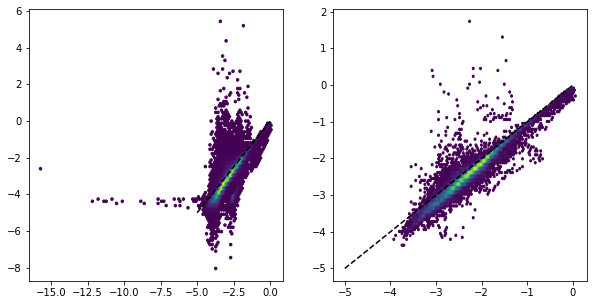

In [81]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].hexbin(Database['log_S_SFR2'],Database['log_S_SFR'],mincnt=1)
axs[1].hexbin(Database.loc[np.floor(Database['Ha_mask'])==1,'log_S_SFR2'],Database.loc[np.floor(Database['Ha_mask'])==1,'log_S_SFR'],mincnt=1)
axs[0].plot([-5,0],[-5,0],c='k',ls='--')
axs[1].plot([-5,0],[-5,0],c='k',ls='--')
plt.show()

In [280]:
Database = []
for source in sources[:]:
    print('\nInitializing source',source)
    z = aca_table.loc[source,'z_stars']
    inc = aca_table.loc[source,'inclination_califa']
    cos = np.cos(np.deg2rad(inc))
    PA = aca_table.loc[source,'PA_califa']-90
    Re = aca_table.loc[source,'Re_arc_califa'] # Effective radius in arcsec
    D_lum = cosmo.luminosity_distance(z)
    D_ang = cosmo.angular_diameter_distance(z)
    #print(f'Luminsoty distance at z = {z:.4}: {D_lum:.5}')
    #print(f'Angular diameter distance at z = {z:.4}: {D_ang:.5}')
    Re = np.deg2rad(Re/3600)*D_ang.to(u.kpc).value # Effective radius in kpc
    hs = Re/(1.68*7.3) # disc scale height in kpc
    QS = aca_table.loc[source,'Final_QS']
    NA = aca_table.loc[source,'Final_NA']
    print(QS,NA)
    
    reduced_cube = SpectralCube.read(acaoutpath+source+'_reduced.fits')
    mom0 = reduced_cube.moment(order=0)
    dec, ra = mom0.world[:]
    ra = ra.value
    dec = dec.value
    rgrid, tgrid = deproject(ra, dec, [PA,inc,aca_table.loc[source,'RA'],aca_table.loc[source,'DEC']])
    rgrid = np.deg2rad(rgrid)*D_ang.to(u.kpc)
    
    CO_int, aca_hdr = get_data(acaoutpath+source+'_integrated.fits',header=True)
    CO_vdisp = get_data(acaoutpath+source+'map_2nd.fits')
    pix_scale_aca = aca_hdr['CDELT2']*3600 # spaxel size in arcsec
    pix_area_aca = ((np.deg2rad(aca_hdr['CDELT2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of ACA spaxel: {pix_scale_aca:.2} arcsec')
    #print(f'Surface area per ACA spaxel: {pix_area_aca:.6}')
    
    M_star, califa_hdr = get_data(califaoutpath+source+'_Mstar.fits',header=True)
    M_star *= 1.6
    region, califa_hdr3D = get_data(califaoutpath+source+'_region.fits',header=True)
    pix_scale_califa = califa_hdr['PC2_2']*3600 # pixel size in arcsec
    pix_area_califa = ((np.deg2rad(califa_hdr['PC2_2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of CALIFA pixel: {pix_scale_califa:.2} arcsec')
    #print(f'Surface area per CALIFA pixel: {pix_area_califa:.6}\n')
    
    Ha_mask = get_data(califaoutpath+source+'_Ha_mask.fits')
    F_NII = get_data(califaoutpath+source+'_F_NII.fits')
    F_OIII = get_data(califaoutpath+source+'_F_OIII.fits')
    F_Ha = get_data(califaoutpath+source+'_F_Ha.fits')
    F_Hb = get_data(califaoutpath+source+'_F_Hb.fits')
    eF_Ha = get_data(califaoutpath+source+'_eF_Ha.fits')
    eF_Hb = get_data(califaoutpath+source+'_eF_Hb.fits')
    califa_hdr3D['NAXIS1'] = 0
    califa_hdr3D['NAXIS2'] = 0

    # convolving CALIFA mpas to ACA resolution
    fwhm_califa = 2.5
    fwhm_aca = 6.
    ppbeam_califa = (fwhm_califa/pix_scale_califa/2)**2 / np.log(2)*np.pi
    ppbeam_aca = (fwhm_aca/pix_scale_aca/2)**2 / np.log(2)*np.pi
    beam_califa = radio_beam.Beam(major=fwhm_califa*u.arcsec, minor=fwhm_califa*u.arcsec, pa=0*u.deg)
    beam_aca = radio_beam.Beam(major=fwhm_aca*u.arcsec, minor=fwhm_aca*u.arcsec, pa=0*u.deg)
    
    frames_cube = SpectralCube(data=np.array([M_star,F_NII,F_OIII,F_Ha,F_Hb,eF_Ha**2,eF_Hb**2]),wcs=WCS(califa_hdr3D))
    frames_cube = frames_cube.with_mask(region)
    frames_cube = frames_cube.with_beam(beam_califa)
    frames_cube_convolved = frames_cube.convolve_to(beam_aca)
    frames_cube_convolved = np.array([frame for frame in frames_cube_convolved])
    frames_cube_convolved[-1] = np.sqrt(frames_cube_convolved[-1])*np.sqrt(ppbeam_califa/ppbeam_aca)
    frames_cube_convolved[-2] = np.sqrt(frames_cube_convolved[-2])*np.sqrt(ppbeam_califa/ppbeam_aca)
    
    area_factor = pix_area_aca.value/pix_area_califa.value
    reprojected_list = area_factor*np.array([reproject_exact((frame,WCS(califa_hdr)),aca_hdr,return_footprint=False) for frame in frames_cube_convolved])
    Ha_mask_rep = reproject_exact((Ha_mask&1,WCS(califa_hdr)),aca_hdr,return_footprint=False)
    
    [M_star_rep,F_NII_rep,F_OIII_rep,F_Ha_rep,F_Hb_rep,eF_Ha_rep,eF_Hb_rep] = reprojected_list
    
    S_star_rep = M_star_rep*cos/pix_area_aca.to(u.kpc**2).value # stellar mass surface density in M_sun pc^-2
    
    Ha_to_Hb_rep = np.where(F_Ha_rep/F_Hb_rep>2.86,F_Ha_rep/F_Hb_rep,2.86) # imposing minimum ratio of 2.86
    Ha_to_Hb_rep = np.where(np.isfinite(F_Ha_rep),Ha_to_Hb_rep,np.nan)
    # from Villanueva et al. 2023
    A_Ha_rep = 5.86*np.log10(Ha_to_Hb_rep/2.86)
    A_Ha_mean_rep = np.nanmean(A_Ha_rep[A_Ha_rep>0])
    A_Ha_rep = np.where(np.isnan(F_Hb_rep)&~np.isnan(F_Ha_rep),A_Ha_mean_rep,A_Ha_rep)
    
    SFR_rep = 1.6*7.9*(10**-(42+16))*F_Ha_rep*np.power(10,A_Ha_rep/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    S_SFR_rep = SFR_rep*cos/pix_area_aca.value
    R_21_rep = S_SFR_rep**0.1
    
    # from Bolatto et al. 2017 and Marino et al. 2013:
    O3N2_rep = np.log10(F_OIII_rep*F_Ha_rep/(F_Hb_rep*F_NII_rep))
    N2_rep = np.log10(F_NII_rep/F_Ha_rep)
    Z_O3N2_rep = np.power(10,-12 + 8.533 - 0.214*O3N2_rep)/Z_sun
    Z_N2_rep = np.power(10,-12 + 8.743 + 0.462*N2_rep)/Z_sun
    
    # from Bolatto et al. 2013
    S_GMC = 1
    # using 10^8 instead of 100 because S_star is in M_sun kpc^-2 instead of M_sun pc^-2
    alphaCO_O3N2_rep = 2.9*np.exp(0.4/(S_GMC*Z_O3N2_rep))*np.power(S_star_rep/10**8,np.where(S_star_rep>10**8,-0.5,0))
    alphaCO_N2_rep = 2.9*np.exp(0.4/(S_GMC*Z_N2_rep))*np.power(S_star_rep/10**8,np.where(S_star_rep>10**8,-0.5,0))
    
    # 10^6 factor converts from pc^-2 in alpha_CO to kpc^-2
    #S_mol_MW  = CO_int*cos*alphaCO_MW      *10**6/R_21_rep
    S_mol_O3N2 = CO_int*cos*alphaCO_O3N2_rep*10**6/R_21_rep
    #S_mol_N2  = CO_int*cos*alphaCO_N2_rep  *10**6/R_21_rep
    
    # from Barrera-Ballesteros et al. 2021
    star_vdisp = np.sqrt(2*np.pi*G*S_star_rep*hs)*u.kpc.to(u.km) # stellar velocity dispersion in km s^-1
    # from Elmegreen et al. 1989
    Ph_rep = (np.pi*G/2)*(S_mol_O3N2+S_H1)*((S_mol_O3N2+S_H1)+S_star_rep*CO_vdisp/star_vdisp)
    Ph_rep = Ph_rep/k_B/(u.kpc**3).to(u.cm**3)
    # from Kim, Kim & Ostriker 2011 and Sun et al. 2020
    Pde_rep = (np.pi*G/2)*(S_mol_O3N2+S_H1)**2 + (S_mol_O3N2+S_H1)*np.sqrt(G*S_star_rep/hs/2)*CO_vdisp/u.kpc.to(u.km)
    Pde_rep = Pde_rep/k_B/(u.kpc**3).to(u.cm**3)
    
    f_CO_rep = S_mol_O3N2/S_star_rep
    sSFR_rep = SFR_rep/M_star_rep
    SFE_rep  = S_SFR_rep/S_mol_O3N2
    flat_region = np.where(M_star_rep.flatten()>0,True,False)

    Partial_Database = pd.DataFrame({'Source':np.broadcast_to(source,S_star_rep.flatten().shape)[flat_region],
                                     'Final_QS':np.broadcast_to(QS,S_star_rep.flatten().shape)[flat_region],
                                     'Final_NA':np.broadcast_to(NA,S_star_rep.flatten().shape)[flat_region],
                                     'Inclination':np.broadcast_to(inc,S_star_rep.flatten().shape)[flat_region],
                                     'PA':np.broadcast_to(PA,S_star_rep.flatten().shape)[flat_region],
                                     'Re_kpc':np.broadcast_to(Re,S_star_rep.flatten().shape)[flat_region],
                                     'RA':ra.flatten()[flat_region],
                                     'DEC':dec.flatten()[flat_region],
                                     'Rgal_kpc':rgrid.flatten()[flat_region],
                                     'T_gal':tgrid.flatten()[flat_region],
                                     'S_Mstar':S_star_rep.flatten()[flat_region],
                                     'S_SFR':S_SFR_rep.flatten()[flat_region],
                                     'Ha_mask':Ha_mask_rep.flatten()[flat_region],
                                     'R_21':R_21_rep.flatten()[flat_region],
                                     'Z_O3N2':Z_O3N2_rep.flatten()[flat_region],
                                     'Z_N2':Z_N2_rep.flatten()[flat_region],
                                     'alphaCO_O3N2':alphaCO_O3N2_rep.flatten()[flat_region],
                                     'alphaCO_N2':alphaCO_N2_rep.flatten()[flat_region],
                                     'S_mol_O3N2':S_mol_O3N2.flatten()[flat_region],
                                     'CO_vdisp':CO_vdisp.flatten()[flat_region],
                                     'star_vdisp':star_vdisp.flatten()[flat_region],
                                     'f_CO':f_CO_rep.flatten()[flat_region],
                                     'sSFR':sSFR_rep.flatten()[flat_region],
                                     'SFE':SFE_rep.flatten()[flat_region],
                                     'P_h':Ph_rep.flatten()[flat_region],
                                     'P_DE':Pde_rep.flatten()[flat_region]})
    Database.append(Partial_Database)


Initializing source CGCG429-012
fR nonA

Initializing source IC1079
MX nonA

Initializing source IC1528
SF nonA

Initializing source IC2341
fR nonA

Initializing source MCG-01-01-012
MX nonA

Initializing source MCG-01-10-015
SF nonA

Initializing source MCG-01-52-012
nR nonA

Initializing source MCG-02-02-030
QnR sAGN

Initializing source MCG-02-51-004
SF nonA

Initializing source NGC0001
SF nonA

Initializing source NGC0155
fR nonA

Initializing source NGC0169
MX wAGN

Initializing source NGC0171
cQ nonA

Initializing source NGC0180
QnR nonA

Initializing source NGC0693
SF nonA

Initializing source NGC0731
fR nonA

Initializing source NGC0768
SF nonA

Initializing source NGC0955
nR nonA

Initializing source NGC1056
SF nonA

Initializing source NGC1542
MX nonA

Initializing source NGC2449
MX nonA

Initializing source NGC2540
SF nonA

Initializing source NGC2554
nR wAGN

Initializing source NGC2595
QnR nonA

Initializing source NGC3300
fR nonA

Initializing source NGC6427
fR nonA

Ini

In [281]:
Database = pd.concat(Database,ignore_index=True)
Database

,Source,Final_QS,Final_NA,Inclination,PA,Re_kpc,RA,DEC,Rgal_kpc,T_gal,...,alphaCO_O3N2,alphaCO_N2,S_mol_O3N2,CO_vdisp,star_vdisp,f_CO,sSFR,SFE,P_h,P_DE
0,CGCG429-012,fR,nonA,59.991884,6.449515,1.397272,339.209394,14.378665,12.518788,-2.541135,...,4.342843,3.992809,NaN,NaN,1.732646,NaN,1.427581e-11,NaN,NaN,NaN
1,CGCG429-012,fR,nonA,59.991884,6.449515,1.397272,339.208964,14.378665,12.002631,-2.617069,...,4.662306,4.193988,NaN,NaN,1.796422,NaN,1.358039e-11,NaN,NaN,NaN
2,CGCG429-012,fR,nonA,59.991884,6.449515,1.397272,339.208534,14.378665,11.561619,-2.699303,...,5.077261,4.663437,NaN,NaN,1.862751,NaN,1.673094e-11,NaN,NaN,NaN
3,CGCG429-012,fR,nonA,59.991884,6.449515,1.397272,339.208104,14.378665,11.204629,-2.787408,...,5.457726,5.266703,NaN,NaN,1.924607,NaN,2.147072e-11,NaN,NaN,NaN
4,CGCG429-012,fR,nonA,59.991884,6.449515,1.397272,339.207244,14.378665,10.774203,-2.977394,...,6.630550,6.229237,NaN,NaN,2.047223,NaN,2.043582e-11,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87458,VV488NED02,SF,nonA,73.160751,68.756316,3.143968,344.205560,-8.962386,29.284013,1.725595,...,6.223236,5.606821,NaN,NaN,2.900236,NaN,5.364717e-10,NaN,NaN,NaN
87459,VV488NED02,SF,nonA,73.160751,68.756316,3.143968,344.205279,-8.962386,29.745294,1.733761,...,6.326578,5.701627,NaN,NaN,2.922467,NaN,5.843134e-10,NaN,NaN,NaN
87460,VV488NED02,SF,nonA,73.160751,68.756316,3.143968,344.216246,-8.961830,16.989412,1.110715,...,5.349539,5.075181,NaN,NaN,4.504568,NaN,4.136860e-11,NaN,NaN,NaN
87461,VV488NED02,SF,nonA,73.160751,68.756316,3.143968,344.216246,-8.961552,18.008724,1.131169,...,5.247439,5.060841,NaN,NaN,4.596295,NaN,4.094734e-11,NaN,NaN,NaN


In [279]:
Database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87463 entries, 0 to 87462
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Source        87463 non-null  object 
 1   Final_QS      87463 non-null  object 
 2   Final_NA      87463 non-null  object 
 3   Inclination   87463 non-null  float64
 4   PA            87463 non-null  float64
 5   Re_kpc        87463 non-null  float64
 6   RA            87463 non-null  float64
 7   DEC           87463 non-null  float64
 8   Rgal_kpc      87463 non-null  float64
 9   T_gal         87463 non-null  float64
 10  S_Mstar       87463 non-null  float64
 11  S_SFR         87463 non-null  float64
 12  Ha_mask       87463 non-null  float64
 13  R_21          87128 non-null  float64
 14  Z_O3N2        80468 non-null  float64
 15  Z_N2          84993 non-null  float64
 16  alphaCO_O3N2  80468 non-null  float64
 17  alphaCO_N2    84993 non-null  float64
 18  S_mol_O3N2    45864 non-nu

In [282]:
Database.to_csv('/users/brodriguez/Documents/ACA_database_'+strftime("%Y-%m-%d",localtime())+'.csv',index=False)

In [199]:
Database_SF = Database[np.floor(Database['Ha_mask'])==1].copy()

In [253]:
Database[Database['S_SFR']<=0]

,Source,Final_QS,Final_NA,Inclination,PA,Re_kpc,RA,DEC,Rgal_kpc,T_gal,...,alphaCO_O3N2,alphaCO_N2,S_mol_O3N2,CO_vdisp,star_vdisp,f_CO,sSFR,SFE,P_h,P_DE
1049,IC1079,MX,nonA,53.368636,172.896524,11.691983,224.156912,9.366043,22.864013,1.146269,...,NaN,NaN,NaN,NaN,24.664842,NaN,-4.365760e-14,NaN,NaN,NaN
1252,IC1079,MX,nonA,53.368636,172.896524,11.691983,224.157757,9.368127,25.222303,1.359905,...,NaN,NaN,NaN,1.268499,34.344806,NaN,-7.468886e-13,NaN,NaN,NaN
1253,IC1079,MX,nonA,53.368636,172.896524,11.691983,224.157335,9.368127,23.773063,1.351517,...,NaN,NaN,NaN,5.795163,34.894878,NaN,-5.559377e-13,NaN,NaN,NaN
1282,IC1079,MX,nonA,53.368636,172.896524,11.691983,224.145088,9.368127,19.234138,-1.465388,...,NaN,4.365923,NaN,NaN,33.995832,NaN,-5.830778e-13,NaN,NaN,NaN
1283,IC1079,MX,nonA,53.368636,172.896524,11.691983,224.144666,9.368127,20.675971,-1.478036,...,3.780694,3.782563,NaN,NaN,32.551349,NaN,-6.173710e-13,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78698,UGC11958,nR,nonA,73.160751,220.452247,7.894817,333.694873,13.850895,45.574827,-1.890821,...,NaN,3.501086,NaN,NaN,12.509861,NaN,-9.445423e-13,NaN,NaN,NaN
78699,UGC11958,nR,nonA,73.160751,220.452247,7.894817,333.694444,13.850895,47.403797,-1.866695,...,NaN,3.859726,NaN,NaN,12.786617,NaN,-3.067064e-12,NaN,NaN,NaN
78700,UGC11958,nR,nonA,73.160751,220.452247,7.894817,333.694015,13.850895,49.258296,-1.844374,...,NaN,3.876753,NaN,NaN,12.805682,NaN,-3.288410e-12,NaN,NaN,NaN
78701,UGC11958,nR,nonA,73.160751,220.452247,7.894817,333.693586,13.850895,51.135548,-1.823682,...,NaN,3.707142,NaN,NaN,12.674554,NaN,-2.081626e-12,NaN,NaN,NaN


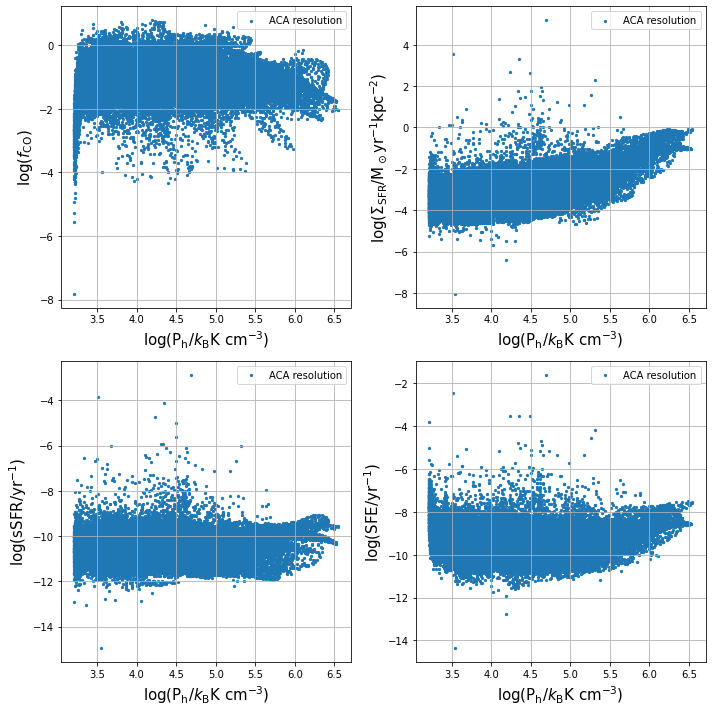

In [201]:
fig, axs = plt.subplots(2,2,figsize=(10,10))#,sharex='col',sharey='row')
for ax,frame,title,label in zip(axs.ravel(),[np.log10(Database['f_CO']),np.log10(Database['S_SFR']),np.log10(Database['sSFR']),np.log10(Database['SFE'])],
                          [r'$f_\mathrm{CO}$',r'$\Sigma_\mathrm{SFR}$','sSFR','SFE'],[r'log($f_\mathrm{CO}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',r'log(sSFR/yr$^{-1}$)',r'log(SFE/yr$^{-1}$)']):
    ax.scatter(np.log10(Database['P_h']),frame,s=5,label='ACA resolution')
    #ax.scatter(np.log10(Ph_hex),frame[1],s=5,label='PyStructure')
    ax.set_ylabel(label,size=15)
    ax.grid(True)
    ax.set_xlabel(r'log(P$_\mathrm{h}$/$k_\mathrm{B}$K cm$^{-3}$)',size=15)
    ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [251]:
high_SFR = Database_SF.loc[Database_SF['sSFR']>10**-8.8].copy()
high_SFR_sources = np.unique(high_SFR['Source'])
high_SFR_sources

array(['IC1528', 'NGC0001', 'NGC1056', 'NGC7364', 'NGC7625', 'NGC7716',
       'UGC00312', 'UGC01368', 'UGC11680NED02', 'UGC11982', 'VV488NED02'],
      dtype=object)

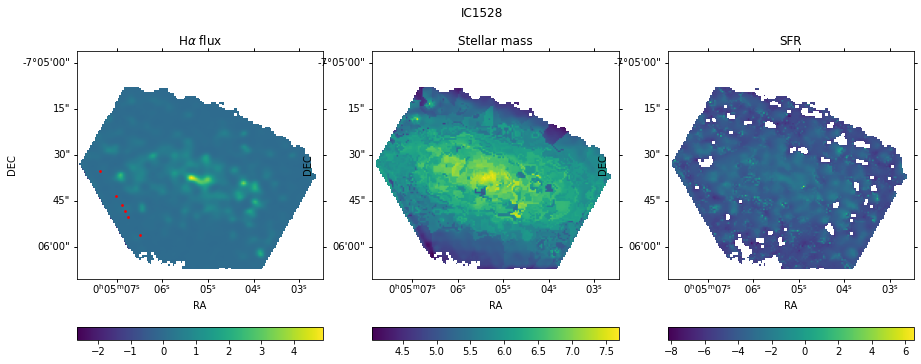

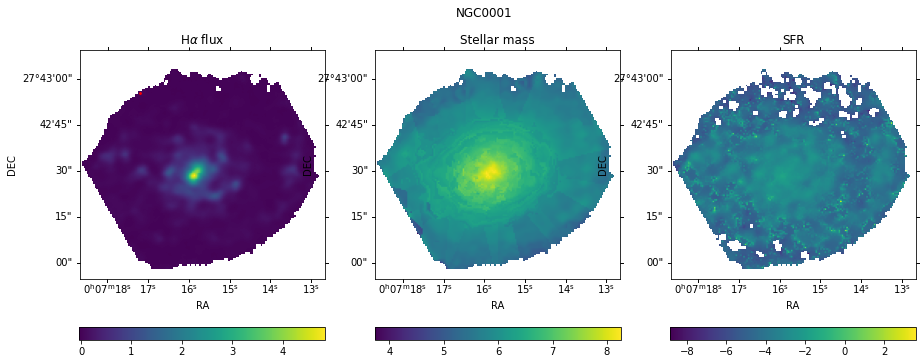

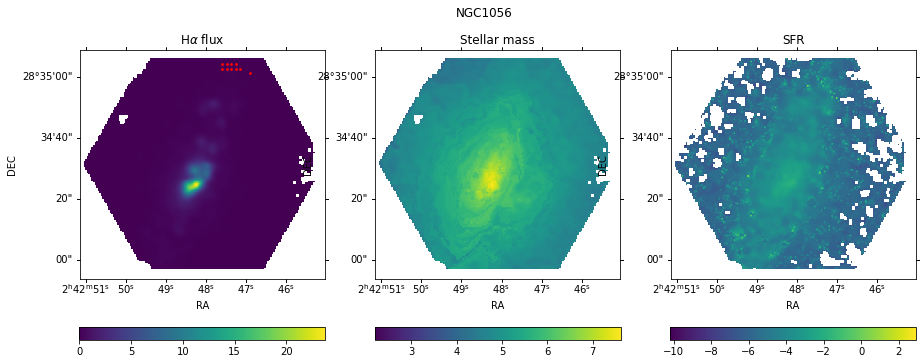

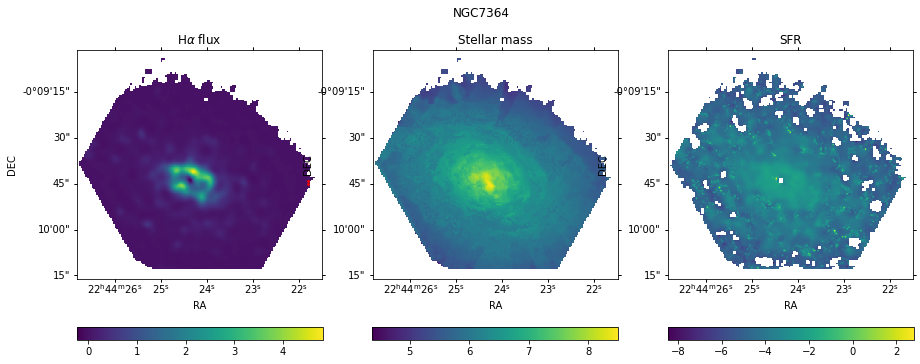

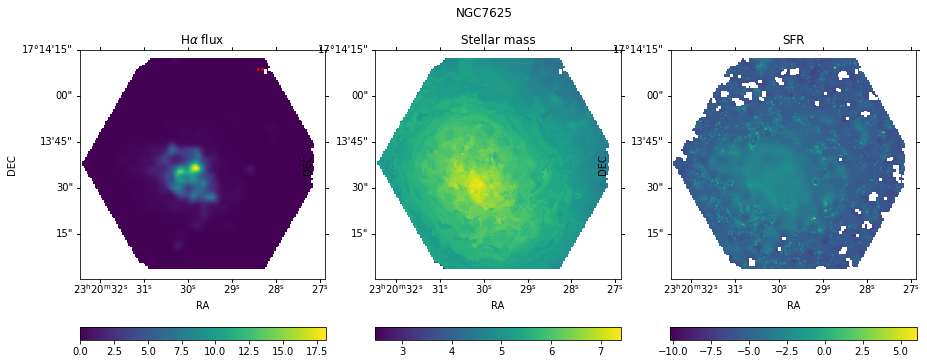

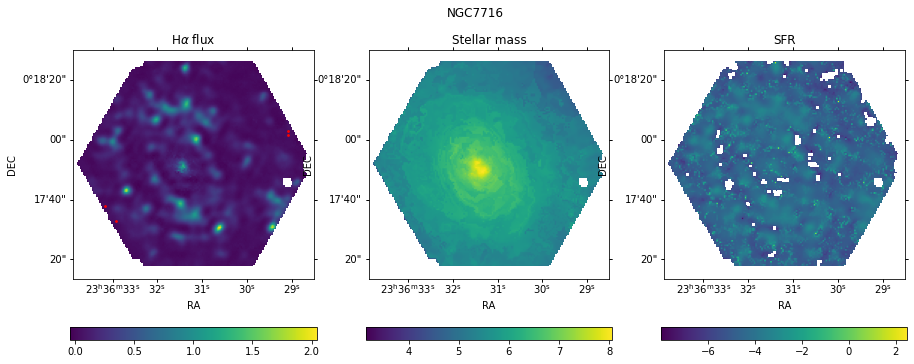

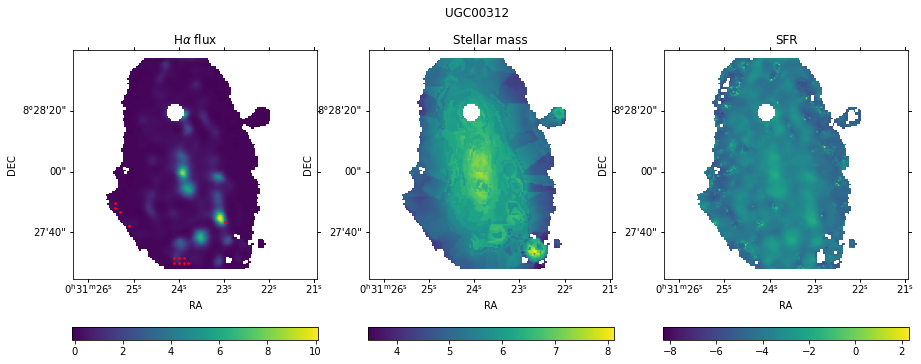

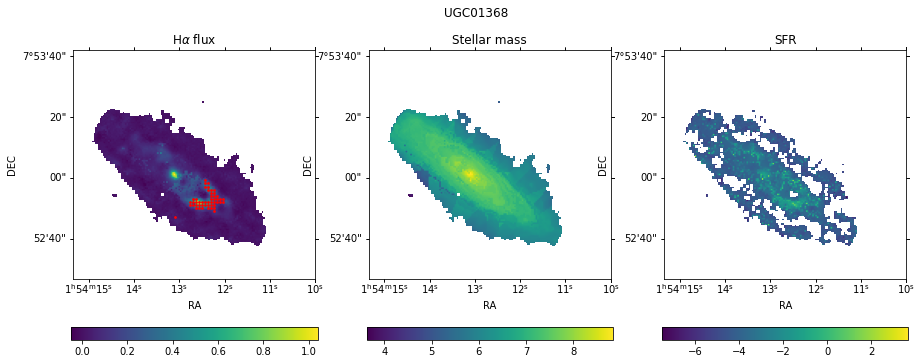

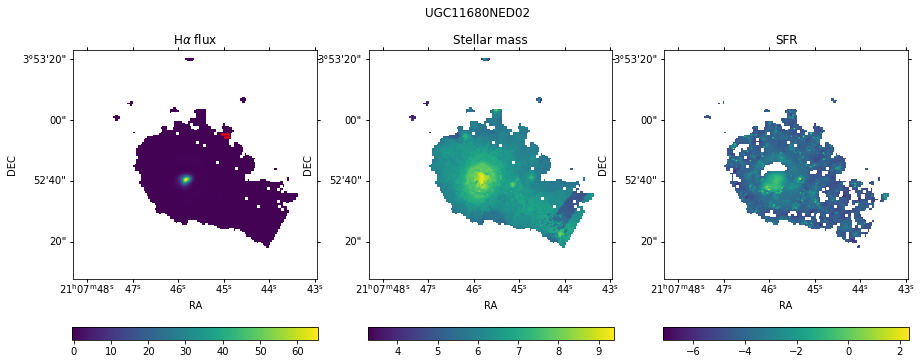

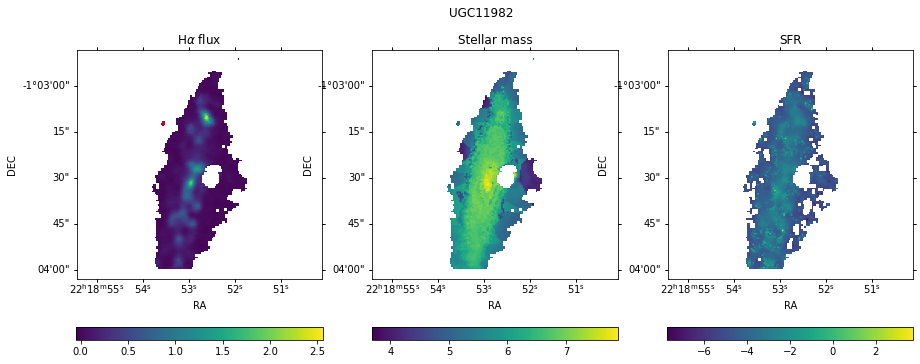

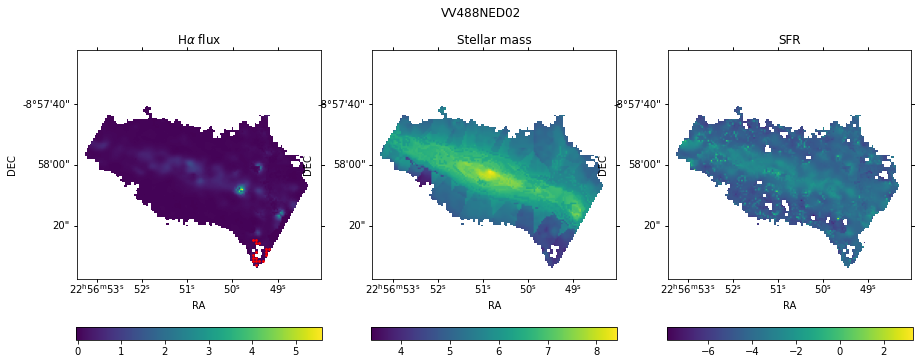

In [252]:
for source in high_SFR_sources[:]:
    M_star, califa_hdr = get_data(califaoutpath+source+'_Mstar.fits',header=True)
    w_califa = WCS(califa_hdr)
    F_Ha = get_data(califaoutpath+source+'_F_Ha.fits')
    F_Hb = get_data(califaoutpath+source+'_F_Hb.fits')

    coords_world = np.array([high_SFR.loc[high_SFR['Source']==source,'RA'].to_numpy(),high_SFR.loc[high_SFR['Source']==source,'DEC'].to_numpy()]).T
    #print(coords_world.shape)
    coords_pixel1 = w_califa.all_world2pix(coords_world, 0).T
    
    D_lum = cosmo.luminosity_distance(aca_table.loc[source,'z_stars'])
    Ha_to_Hb = np.where(F_Ha/F_Hb>2.86,F_Ha/F_Hb,2.86) # imposing minimum ratio of 2.86
    Ha_to_Hb = np.where(np.isfinite(F_Ha),Ha_to_Hb,np.nan)
    # from Villanueva et al. 2023
    A_Ha = 5.86*np.log10(Ha_to_Hb/2.86)
    A_Ha_mean = np.nanmean(A_Ha[A_Ha>0])
    A_Ha = np.where(np.isnan(F_Hb)&~np.isnan(F_Ha),A_Ha_mean,A_Ha)
    SFR = 1.61*7.9*(10**-(42+16))*F_Ha*np.power(10,A_Ha/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    

    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(1,3,1,projection=w_califa)
    ax2 = fig.add_subplot(1,3,2,projection=w_califa)
    ax3 = fig.add_subplot(1,3,3,projection=w_califa)
    for ax,frame,label in zip([ax1,ax2,ax3],[F_Ha,np.log10(M_star),np.log10(SFR)],
                              [r'H$\alpha$ flux',r'Stellar mass',r'SFR']):
        im = ax.imshow(frame, origin='lower')
        fig.colorbar(im,ax=ax,orientation='horizontal')
        ax.set_title(label)#,fontsize=15)
        ax.coords['ra'].set_axislabel('RA')
        ax.coords['dec'].set_axislabel('DEC')
    ax1.scatter(coords_pixel1[0],coords_pixel1[1],c='r',s=3)#,label='ACA $R_e$')
    #ax2.scatter(coords_pixel1[0],coords_pixel1[1],c='r',s=3)
    fig.suptitle(source)
    plt.show()
    plt.close()

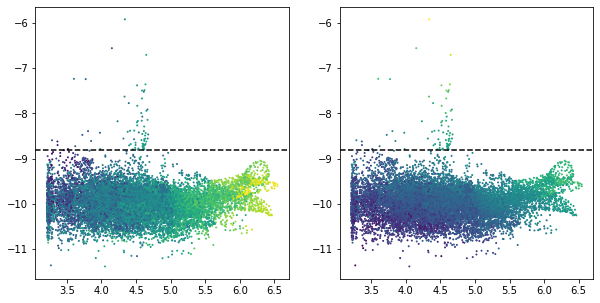

In [260]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].scatter(np.log10(Database_SF['P_h']),np.log10(Database_SF['sSFR']),s=1,c=np.log10(Database_SF['S_Mstar']))
axs[1].scatter(np.log10(Database_SF['P_h']),np.log10(Database_SF['sSFR']),s=1,c=np.log10(Database_SF['S_SFR']))
axs[0].axhline(-8.8,c='k',ls='--')
axs[1].axhline(-8.8,c='k',ls='--')
plt.show()

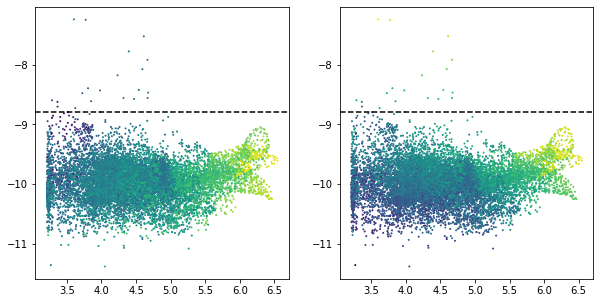

In [277]:
sample = Database_SF[Database_SF['Inclination']<70].copy()
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].scatter(np.log10(sample['P_h']),np.log10(sample['sSFR']),s=1,c=np.log10(sample['S_Mstar']))
axs[1].scatter(np.log10(sample['P_h']),np.log10(sample['sSFR']),s=1,c=np.log10(sample['S_SFR']))
axs[0].axhline(-8.8,c='k',ls='--')
axs[1].axhline(-8.8,c='k',ls='--')
plt.show()

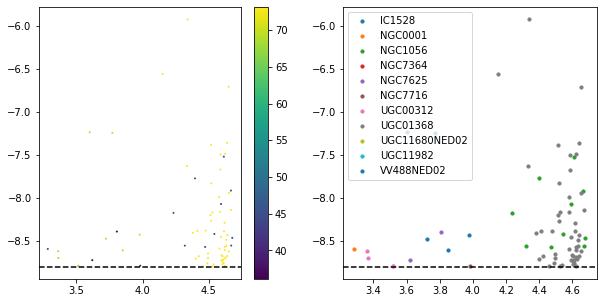

In [272]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
scatter = axs[0].scatter(np.log10(high_SFR['P_h']),np.log10(high_SFR['sSFR']),s=1,c=high_SFR['Inclination'])
fig.colorbar(scatter,ax=axs[0])
for source in high_SFR_sources:
    axs[1].scatter(np.log10(high_SFR.loc[high_SFR['Source']==source,'P_h']),np.log10(high_SFR.loc[high_SFR['Source']==source,'sSFR']),s=10,label=source)
axs[1].legend()    
axs[0].axhline(-8.8,c='k',ls='--')
axs[1].axhline(-8.8,c='k',ls='--')
plt.show()

In [209]:
Database_SF['log_S_Mstar'] = np.log10(Database_SF.loc[:,'S_Mstar'])
Database_SF['log_S_mol_O3N2'] = np.log10(Database_SF.loc[:,'S_mol_O3N2'])
Database_SF['log_P_h'] = np.log10(Database_SF.loc[:,'P_h'])
Database_SF['log_f_CO'] = np.log10(Database_SF.loc[:,'f_CO'])
Database_SF['log_S_SFR'] = np.log10(Database_SF.loc[:,'S_SFR'])
Database_SF['log_sSFR'] = np.log10(Database_SF.loc[:,'sSFR'])
Database_SF['log_SFE'] = np.log10(Database_SF.loc[:,'SFE'])

In [212]:
A = 0.3
b = 0.95

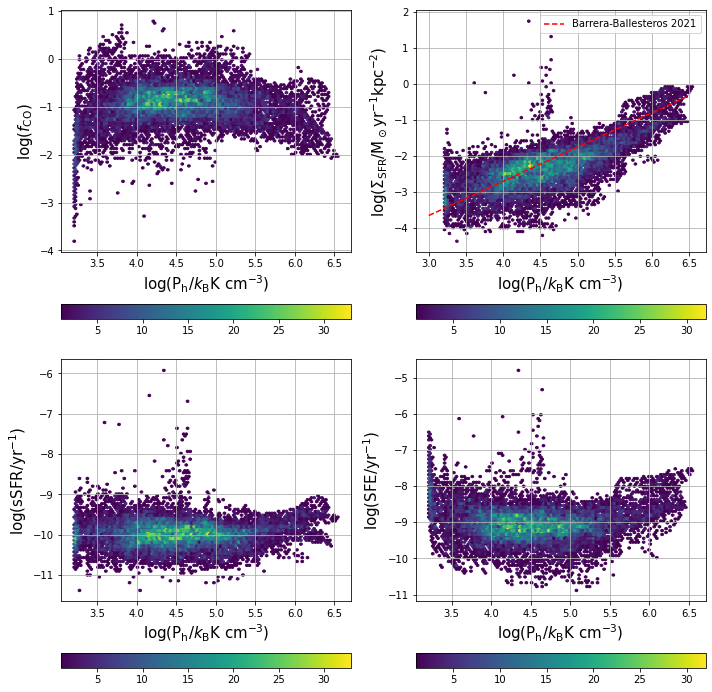

In [213]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
for ax,frame,title,label in zip(axs.ravel(),[Database_SF['log_f_CO'],Database_SF['log_S_SFR'],Database_SF['log_sSFR'],Database_SF['log_SFE']],
                          [r'$f_\mathrm{CO}$',r'$\Sigma_\mathrm{SFR}$','sSFR','SFE'],[r'log($f_\mathrm{CO}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',r'log(sSFR/yr$^{-1}$)',r'log(SFE/yr$^{-1}$)']):
    im = ax.hexbin(Database_SF['log_P_h'],frame,mincnt=1)
    fig.colorbar(im,ax=ax,orientation='horizontal')
    ax.set_ylabel(label,size=15)
    ax.grid(True)
    ax.set_xlabel(r'log(P$_\mathrm{h}$/$k_\mathrm{B}$K cm$^{-3}$)',size=15)
    
axs[0,1].plot([3.,6.5],[b*(3.-4)+A-3,b*(6.5-4)+A-3],c='r',ls='--',label='Barrera-Ballesteros 2021')
axs[0,1].legend(loc='best')
fig.tight_layout()
plt.show()

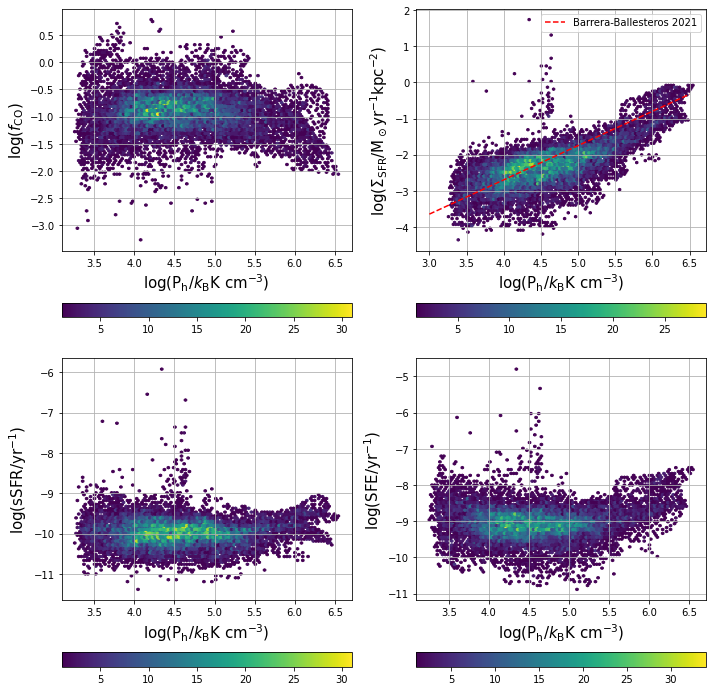

In [214]:
sample = Database_SF[np.log10(Database_SF['CO_vdisp'])>-2].copy()
fig, axs = plt.subplots(2,2,figsize=(10,10))
for ax,frame,title,label in zip(axs.ravel(),[sample['log_f_CO'],sample['log_S_SFR'],sample['log_sSFR'],sample['log_SFE']],
                          [r'$f_\mathrm{CO}$',r'$\Sigma_\mathrm{SFR}$','sSFR','SFE'],[r'log($f_\mathrm{CO}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',r'log(sSFR/yr$^{-1}$)',r'log(SFE/yr$^{-1}$)']):
    im = ax.hexbin(sample['log_P_h'],frame,mincnt=1)
    fig.colorbar(im,ax=ax,orientation='horizontal')
    ax.set_ylabel(label,size=15)
    ax.grid(True)
    ax.set_xlabel(r'log(P$_\mathrm{h}$/$k_\mathrm{B}$K cm$^{-3}$)',size=15)
    
axs[0,1].plot([3.,6.5],[b*(3.-4)+A-3,b*(6.5-4)+A-3],c='r',ls='--',label='Barrera-Ballesteros 2021')
axs[0,1].legend(loc='best')
fig.tight_layout()
plt.show()

(1.0, 1.0, 1.0, 1.0)
(1.0, 1.0, 1.0, 1.0)


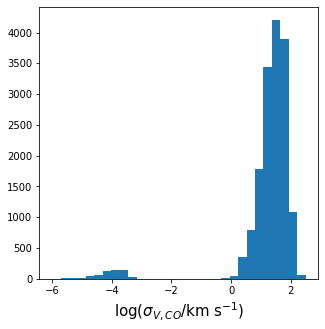

In [232]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(np.log10(Database_SF['CO_vdisp']),bins=np.linspace(-6,2.5,31))
ax.set_xlabel('log($\sigma_{V,CO}$/km s$^{-1}$)',fontsize=15)
print(ax.get_facecolor())
#fig.set_facecolor((0.,0.,0.,0.))
print(fig.get_facecolor())
plt.show()

(1.0, 1.0, 1.0, 1.0)
(1.0, 1.0, 1.0, 1.0)


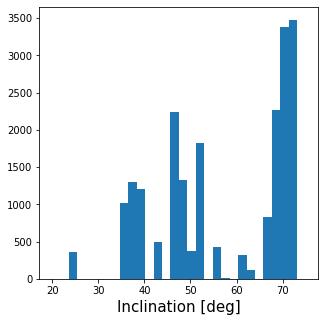

In [275]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(Database_SF['Inclination'],bins=np.linspace(20,75,31))
ax.set_xlabel('Inclination [deg]',fontsize=15)
print(ax.get_facecolor())
#fig.set_facecolor((0.,0.,0.,0.))
print(fig.get_facecolor())
plt.show()


Initializing source CGCG429-012
Luminsoty distance at z = 0.01746: 76.125 Mpc
fR nonA
9.000000000001293
1.25000000000009


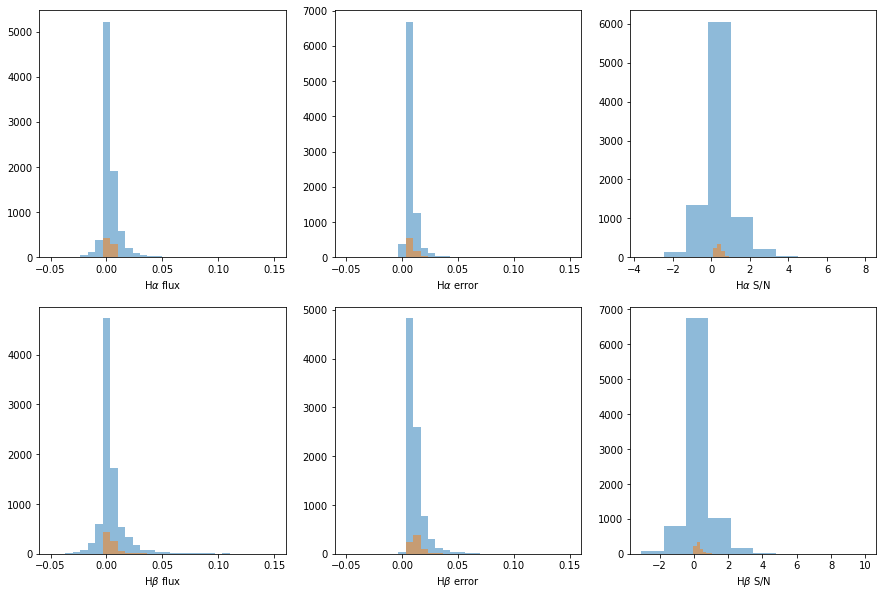

True
True
True


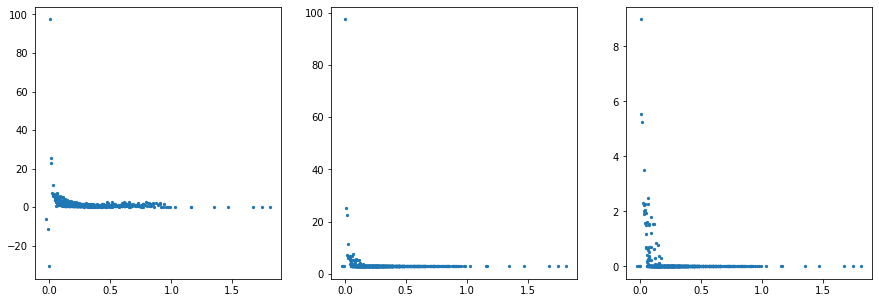

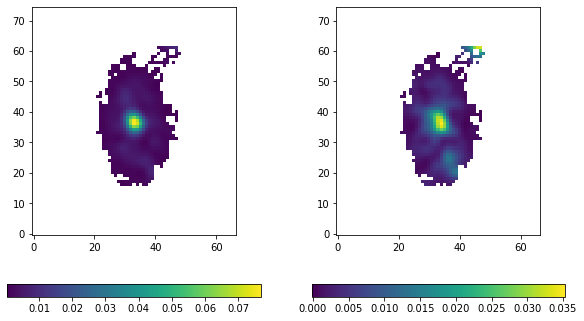

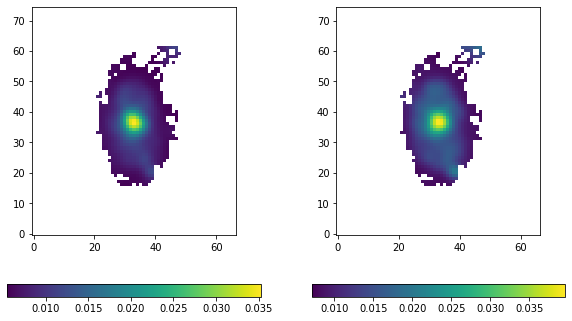

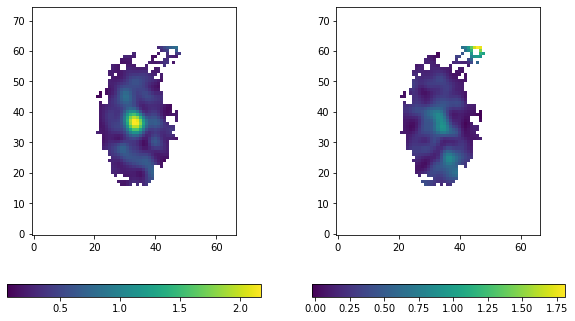

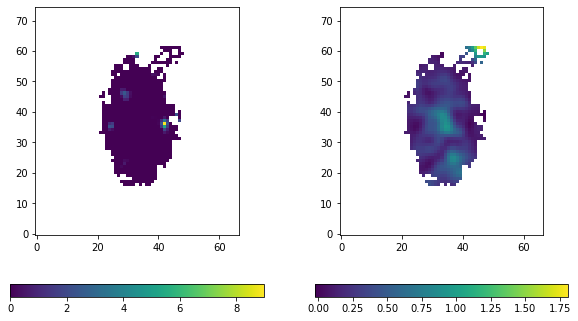

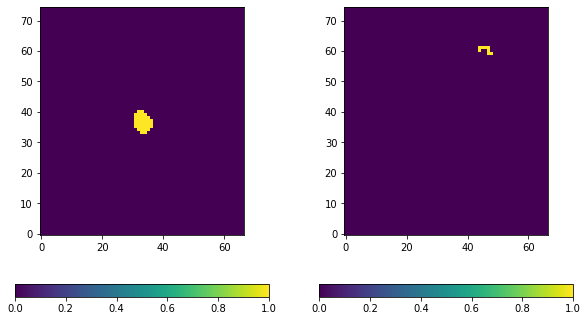

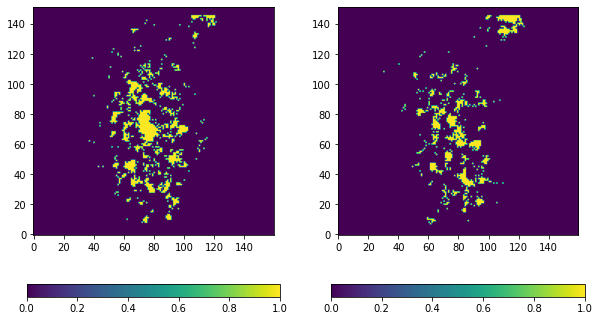

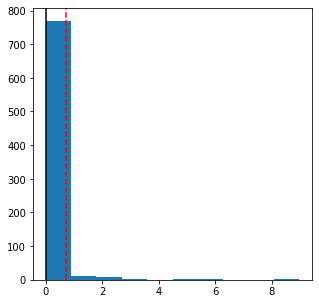

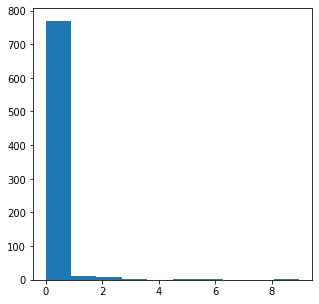

In [250]:
for source in sources[:1]:
    print('\nInitializing source',source)
    z = califa_table.loc[source,'z_stars']
    inc = aca_table.loc[source,'inclination_califa']
    cos = np.cos(np.deg2rad(inc))
    PA = aca_table.loc[source,'PA_califa']
    Re = califa_table.loc[source,'Re_kpc'] # Effective radius in kpc
    hs = Re/(1.68*7.3) # disc scale height in kpc
    D_lum = cosmo.luminosity_distance(z)
    D_ang = cosmo.angular_diameter_distance(z)
    print(f'Luminsoty distance at z = {z:.4}: {D_lum:.5}')
    #print(f'Angular diameter distance at z = {z:.4}: {D_ang:.5}')
    QS = aca_table.loc[source,'Final_QS']
    NA = aca_table.loc[source,'Final_NA']
    print(QS,NA)
    
    #reduced_cube = SpectralCube.read(acaoutpath+source+'_reduced.fits')
    #mom0 = reduced_cube.moment(order=0)
    #dec, ra = mom0.world[:]
    #ra = ra.value
    #dec = dec.value
    #rgrid, tgrid = deproject(ra, dec, [PA,inc,aca_table.loc[source,'RA'],aca_table.loc[source,'DEC']])
    #rgrid = np.deg2rad(rgrid)*D_ang.to(u.kpc)
    
    CO_int, aca_hdr = get_data(acaoutpath+source+'_integrated.fits',header=True)
    CO_vdisp = get_data(acaoutpath+source+'map_2nd.fits')
    pix_scale_aca = aca_hdr['CDELT2']*3600 # spaxel size in arcsec
    pix_area_aca = ((np.deg2rad(aca_hdr['CDELT2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of ACA spaxel: {pix_scale_aca:.2} arcsec')
    #print(f'Surface area per ACA spaxel: {pix_area_aca:.6}')
    
    M_star, califa_hdr = get_data(califaoutpath+source+'_Mstar.fits',header=True)
    region, califa_hdr3D = get_data(califaoutpath+source+'_region.fits',header=True)
    pix_scale_califa = califa_hdr['PC2_2']*3600 # pixel size in arcsec
    pix_area_califa = ((np.deg2rad(califa_hdr['PC2_2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of CALIFA pixel: {pix_scale_califa:.2} arcsec')
    #print(f'Surface area per CALIFA pixel: {pix_area_califa:.6}\n')
    
    Ha_mask = get_data(califaoutpath+source+'_Ha_mask.fits')
    F_NII = get_data(califaoutpath+source+'_F_NII.fits')
    F_OIII = get_data(califaoutpath+source+'_F_OIII.fits')
    F_Ha = get_data(califaoutpath+source+'_F_Ha.fits')
    F_Hb = get_data(califaoutpath+source+'_F_Hb.fits')
    eF_Ha = get_data(califaoutpath+source+'_eF_Ha.fits')
    eF_Hb = get_data(califaoutpath+source+'_eF_Hb.fits')
    califa_hdr3D['NAXIS1'] = 0
    califa_hdr3D['NAXIS2'] = 0
    #print(califa_hdr)
    #print(WCS(califa_hdr3D))
    #print(WCS(califa_hdr))
    # convolving CALIFA mpas to ACA resolution
    fwhm_califa = 2.5
    fwhm_aca = 6.
    ppbeam_califa = (fwhm_califa/pix_scale_califa/2)**2 / np.log(2)*np.pi
    ppbeam_aca = (fwhm_aca/pix_scale_aca/2)**2 / np.log(2)*np.pi
    beam_califa = radio_beam.Beam(major=fwhm_califa*u.arcsec, minor=fwhm_califa*u.arcsec, pa=0*u.deg)
    beam_aca = radio_beam.Beam(major=fwhm_aca*u.arcsec, minor=fwhm_aca*u.arcsec, pa=0*u.deg)
    area_factor = pix_area_aca.value/pix_area_califa.value
    scale_factor = np.sqrt(ppbeam_califa/ppbeam_aca)
    
    frames_cube = SpectralCube(data=np.array([M_star,F_NII,F_OIII,F_Ha,F_Hb,eF_Ha**2,eF_Hb**2]),wcs=WCS(califa_hdr3D))
    frames_cube = frames_cube.with_mask(region)
    frames_cube = frames_cube.with_beam(beam_califa)
    frames_cube_convolved = frames_cube.convolve_to(beam_aca)
    frames_cube_convolved = np.array([frame for frame in frames_cube_convolved])
    #frames_cube_convolved[0:5] *= area_factor
    frames_cube_convolved[-1] = np.sqrt(frames_cube_convolved[-1])#*scale_factor
    frames_cube_convolved[-2] = np.sqrt(frames_cube_convolved[-2])#*scale_factor
    
    print(area_factor)
    print(np.sqrt(ppbeam_califa/ppbeam_aca))
    reprojected_list = np.array([reproject_exact((frame,WCS(califa_hdr)),aca_hdr,return_footprint=False) for frame in frames_cube_convolved])
    Ha_mask_rep = reproject_exact((Ha_mask&1,WCS(califa_hdr)),aca_hdr,return_footprint=False)
    
    [M_star_rep,F_NII_rep,F_OIII_rep,F_Ha_rep,F_Hb_rep,eF_Ha_rep,eF_Hb_rep] = reprojected_list
    
    S_star_rep = M_star_rep*cos/pix_area_aca.to(u.kpc**2).value # stellar mass surface density in M_sun pc^-2
        
    Ha_to_Hb_rep = np.where(F_Ha_rep/F_Hb_rep>2.86,F_Ha_rep/F_Hb_rep,2.86) # imposing minimum ratio of 2.86
    Ha_to_Hb_rep = np.where(np.isfinite(F_Ha_rep),Ha_to_Hb_rep,np.nan)
    
    fig, axs = plt.subplots(2,3,figsize=(15,10))
    axs[0,0].hist(F_Ha.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[0,0].hist(F_Ha_rep.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[0,0].set_xlabel(r'H$\alpha$ flux')
    axs[0,1].hist(eF_Ha.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[0,1].hist(eF_Ha_rep.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[0,1].set_xlabel(r'H$\alpha$ error')
    axs[0,2].hist(F_Ha.flatten()/eF_Ha.flatten(),alpha=0.5)#,bins=np.linspace(-0.05,0.15,31))
    axs[0,2].hist(F_Ha_rep.flatten()/eF_Ha_rep.flatten(),alpha=0.5)#,bins=np.linspace(-0.05,0.15,31))
    axs[0,2].set_xlabel(r'H$\alpha$ S/N')
    axs[1,0].hist(F_Hb.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[1,0].hist(F_Hb_rep.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[1,0].set_xlabel(r'H$\beta$ flux')
    axs[1,1].hist(eF_Hb.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[1,1].hist(eF_Hb_rep.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[1,1].set_xlabel(r'H$\beta$ error')
    axs[1,2].hist(F_Hb.flatten()/eF_Hb.flatten(),alpha=0.5)#,bins=np.linspace(-0.05,0.15,31))
    axs[1,2].hist(F_Hb_rep.flatten()/eF_Hb_rep.flatten(),alpha=0.5)#,bins=np.linspace(-0.05,0.15,31))
    axs[1,2].set_xlabel(r'H$\beta$ S/N')
    
    #ax[,].axvline(A_Ha_mean_rep,c='k',ls='-')
    #ax[,].axvline(A_Ha_median_rep,c='r',ls='--')
    plt.show()
    
    # from Villanueva et al. 2023
    A_Ha_rep = 5.86*np.log10(Ha_to_Hb_rep/2.86)
    
    print((F_Ha_rep>eF_Ha_rep).any())
    print((F_Hb_rep>eF_Hb_rep).any())
    print(((A_Ha_rep>=0)&(F_Hb_rep>eF_Hb_rep)).any())
    
    fig, axs = plt.subplots(1,3,figsize=(15,5))
    axs[0].scatter(F_Hb_rep/eF_Hb_rep,F_Ha_rep/F_Hb_rep,s=5)
    axs[1].scatter(F_Hb_rep/eF_Hb_rep,Ha_to_Hb_rep,s=5)
    axs[2].scatter(F_Hb_rep/eF_Hb_rep,A_Ha_rep,s=5)
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(F_Ha_rep,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(F_Hb_rep,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(eF_Ha_rep,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(eF_Hb_rep,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(F_Ha_rep/eF_Ha_rep,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(F_Hb_rep/eF_Hb_rep,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(A_Ha_rep,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(F_Hb_rep/eF_Hb_rep,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(F_Ha_rep/eF_Ha_rep>1,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(F_Hb_rep/eF_Hb_rep>1,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(F_Ha/eF_Ha>1,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(F_Hb/eF_Hb>1,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    A_Ha_mean_rep = np.nanmean(A_Ha_rep[A_Ha_rep>0])
    A_Ha_mean_rep = np.nanmean(A_Ha_rep[(A_Ha_rep>=0)&(F_Hb_rep>eF_Hb_rep)])
    A_Ha_median_rep = np.nanmedian(A_Ha_rep[A_Ha_rep>0])
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist(A_Ha_rep.flatten())
    ax.axvline(A_Ha_mean_rep,c='k',ls='-')
    ax.axvline(A_Ha_median_rep,c='r',ls='--')
    plt.show()
    
    #A_Ha_rep = np.where(~(F_Hb_rep>eF_Hb_rep)&~np.isnan(F_Ha_rep),A_Ha_mean_rep,A_Ha_rep)
    
    A_Ha_rep = np.where(np.isnan(F_Hb_rep)&~np.isnan(F_Ha_rep),A_Ha_median_rep,A_Ha_rep)
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist(A_Ha_rep.flatten())
    #ax.axvline(A_Ha_mean_rep,c='k',ls='-')
    #ax.axvline(A_Ha_median_rep,c='r',ls='--')
    plt.show()
    
    SFR_rep = 1.61*7.9*(10**-(42+16))*F_Ha_rep*np.power(10,A_Ha_rep/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    S_SFR_rep = SFR_rep*cos/pix_area_aca.value



Initializing source UGC01368
Luminsoty distance at z = 0.02652: 116.39 Mpc
SF nonA
4.000000000000577
0.8333333333333932


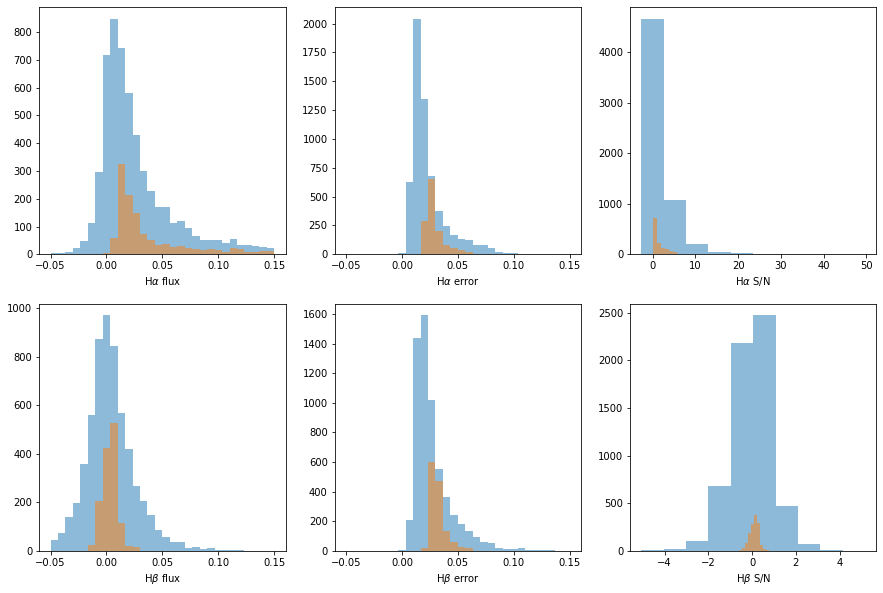

True
False
False


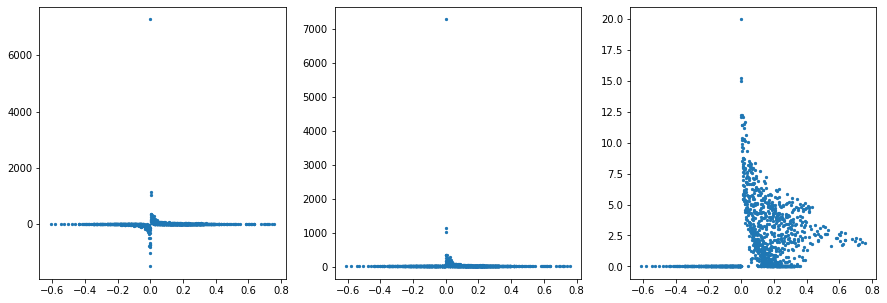

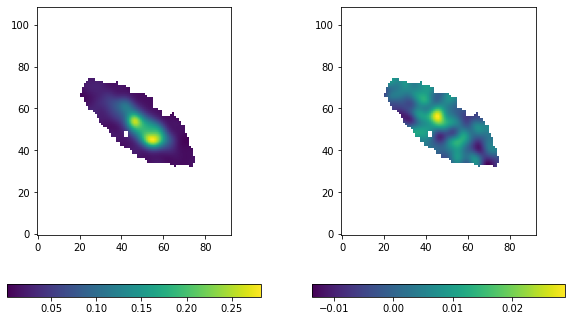

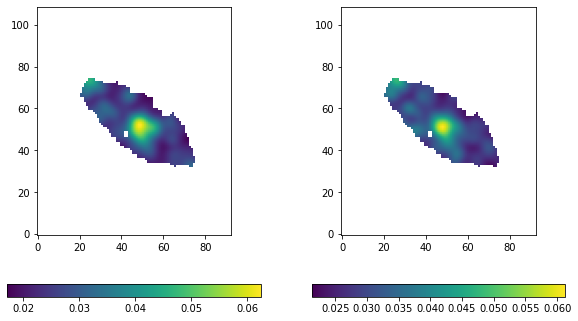

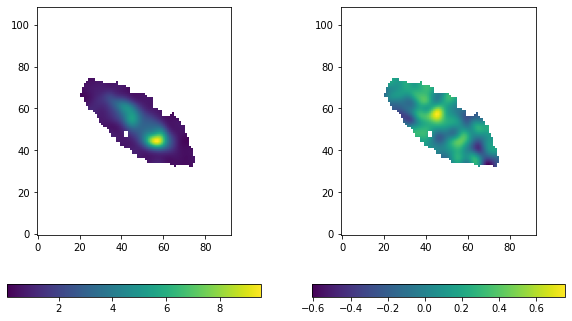

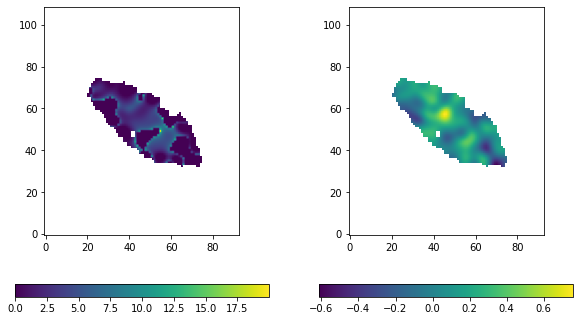

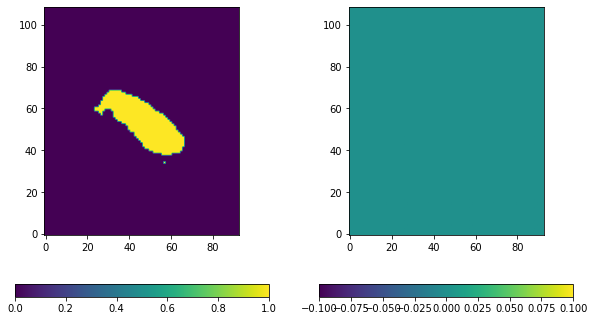

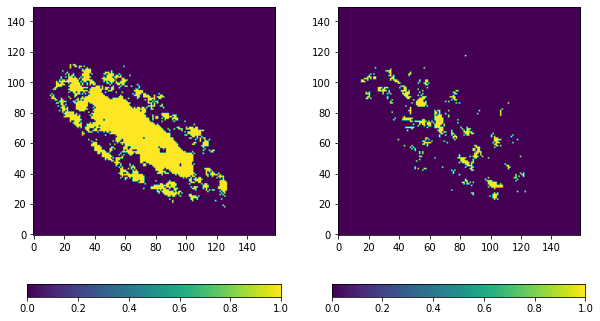

/tmp/ipykernel_870345/2200876307.py:162: RuntimeWarning: Mean of empty slice
  A_Ha_mean_rep = np.nanmean(A_Ha_rep[(A_Ha_rep>=0)&(F_Hb_rep>eF_Hb_rep)])


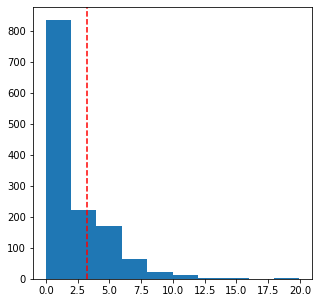

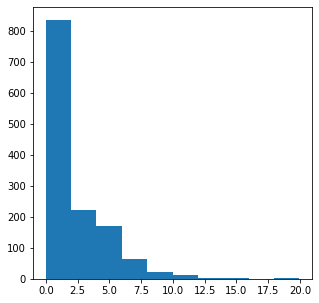

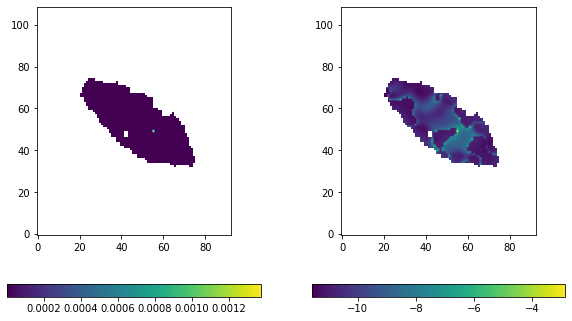

In [258]:
for source in ['UGC01368']:
    print('\nInitializing source',source)
    z = califa_table.loc[source,'z_stars']
    inc = aca_table.loc[source,'inclination_califa']
    cos = np.cos(np.deg2rad(inc))
    PA = aca_table.loc[source,'PA_califa']
    Re = califa_table.loc[source,'Re_kpc'] # Effective radius in kpc
    hs = Re/(1.68*7.3) # disc scale height in kpc
    D_lum = cosmo.luminosity_distance(z)
    D_ang = cosmo.angular_diameter_distance(z)
    print(f'Luminsoty distance at z = {z:.4}: {D_lum:.5}')
    #print(f'Angular diameter distance at z = {z:.4}: {D_ang:.5}')
    QS = aca_table.loc[source,'Final_QS']
    NA = aca_table.loc[source,'Final_NA']
    print(QS,NA)
    
    #reduced_cube = SpectralCube.read(acaoutpath+source+'_reduced.fits')
    #mom0 = reduced_cube.moment(order=0)
    #dec, ra = mom0.world[:]
    #ra = ra.value
    #dec = dec.value
    #rgrid, tgrid = deproject(ra, dec, [PA,inc,aca_table.loc[source,'RA'],aca_table.loc[source,'DEC']])
    #rgrid = np.deg2rad(rgrid)*D_ang.to(u.kpc)
    
    CO_int, aca_hdr = get_data(acaoutpath+source+'_integrated.fits',header=True)
    CO_vdisp = get_data(acaoutpath+source+'map_2nd.fits')
    pix_scale_aca = aca_hdr['CDELT2']*3600 # spaxel size in arcsec
    pix_area_aca = ((np.deg2rad(aca_hdr['CDELT2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of ACA spaxel: {pix_scale_aca:.2} arcsec')
    #print(f'Surface area per ACA spaxel: {pix_area_aca:.6}')
    
    M_star, califa_hdr = get_data(califaoutpath+source+'_Mstar.fits',header=True)
    region, califa_hdr3D = get_data(califaoutpath+source+'_region.fits',header=True)
    pix_scale_califa = califa_hdr['PC2_2']*3600 # pixel size in arcsec
    pix_area_califa = ((np.deg2rad(califa_hdr['PC2_2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of CALIFA pixel: {pix_scale_califa:.2} arcsec')
    #print(f'Surface area per CALIFA pixel: {pix_area_califa:.6}\n')
    
    Ha_mask = get_data(califaoutpath+source+'_Ha_mask.fits')
    F_NII = get_data(califaoutpath+source+'_F_NII.fits')
    F_OIII = get_data(califaoutpath+source+'_F_OIII.fits')
    F_Ha = get_data(califaoutpath+source+'_F_Ha.fits')
    F_Hb = get_data(califaoutpath+source+'_F_Hb.fits')
    eF_Ha = get_data(califaoutpath+source+'_eF_Ha.fits')
    eF_Hb = get_data(califaoutpath+source+'_eF_Hb.fits')
    califa_hdr3D['NAXIS1'] = 0
    califa_hdr3D['NAXIS2'] = 0
    #print(califa_hdr)
    #print(WCS(califa_hdr3D))
    #print(WCS(califa_hdr))
    # convolving CALIFA mpas to ACA resolution
    fwhm_califa = 2.5
    fwhm_aca = 6.
    ppbeam_califa = (fwhm_califa/pix_scale_califa/2)**2 / np.log(2)*np.pi
    ppbeam_aca = (fwhm_aca/pix_scale_aca/2)**2 / np.log(2)*np.pi
    beam_califa = radio_beam.Beam(major=fwhm_califa*u.arcsec, minor=fwhm_califa*u.arcsec, pa=0*u.deg)
    beam_aca = radio_beam.Beam(major=fwhm_aca*u.arcsec, minor=fwhm_aca*u.arcsec, pa=0*u.deg)
    area_factor = pix_area_aca.value/pix_area_califa.value
    scale_factor = np.sqrt(ppbeam_califa/ppbeam_aca)
    
    frames_cube = SpectralCube(data=np.array([M_star,F_NII,F_OIII,F_Ha,F_Hb,eF_Ha**2,eF_Hb**2]),wcs=WCS(califa_hdr3D))
    frames_cube = frames_cube.with_mask(region)
    frames_cube = frames_cube.with_beam(beam_califa)
    frames_cube_convolved = frames_cube.convolve_to(beam_aca)
    frames_cube_convolved = np.array([frame for frame in frames_cube_convolved])
    #frames_cube_convolved[0:5] *= area_factor
    frames_cube_convolved[-1] = np.sqrt(frames_cube_convolved[-1])#*scale_factor
    frames_cube_convolved[-2] = np.sqrt(frames_cube_convolved[-2])#*scale_factor
    
    print(area_factor)
    print(np.sqrt(ppbeam_califa/ppbeam_aca))
    reprojected_list = np.array([reproject_exact((frame,WCS(califa_hdr)),aca_hdr,return_footprint=False) for frame in frames_cube_convolved])
    Ha_mask_rep = reproject_exact((Ha_mask&1,WCS(califa_hdr)),aca_hdr,return_footprint=False)
    
    [M_star_rep,F_NII_rep,F_OIII_rep,F_Ha_rep,F_Hb_rep,eF_Ha_rep,eF_Hb_rep] = reprojected_list
    
    S_star_rep = M_star_rep*cos/pix_area_aca.to(u.kpc**2).value # stellar mass surface density in M_sun pc^-2
        
    Ha_to_Hb_rep = np.where(F_Ha_rep/F_Hb_rep>2.86,F_Ha_rep/F_Hb_rep,2.86) # imposing minimum ratio of 2.86
    Ha_to_Hb_rep = np.where(np.isfinite(F_Ha_rep),Ha_to_Hb_rep,np.nan)
    
    fig, axs = plt.subplots(2,3,figsize=(15,10))
    axs[0,0].hist(F_Ha.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[0,0].hist(F_Ha_rep.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[0,0].set_xlabel(r'H$\alpha$ flux')
    axs[0,1].hist(eF_Ha.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[0,1].hist(eF_Ha_rep.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[0,1].set_xlabel(r'H$\alpha$ error')
    axs[0,2].hist(F_Ha.flatten()/eF_Ha.flatten(),alpha=0.5)#,bins=np.linspace(-0.05,0.15,31))
    axs[0,2].hist(F_Ha_rep.flatten()/eF_Ha_rep.flatten(),alpha=0.5)#,bins=np.linspace(-0.05,0.15,31))
    axs[0,2].set_xlabel(r'H$\alpha$ S/N')
    axs[1,0].hist(F_Hb.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[1,0].hist(F_Hb_rep.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[1,0].set_xlabel(r'H$\beta$ flux')
    axs[1,1].hist(eF_Hb.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[1,1].hist(eF_Hb_rep.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[1,1].set_xlabel(r'H$\beta$ error')
    axs[1,2].hist(F_Hb.flatten()/eF_Hb.flatten(),alpha=0.5)#,bins=np.linspace(-0.05,0.15,31))
    axs[1,2].hist(F_Hb_rep.flatten()/eF_Hb_rep.flatten(),alpha=0.5)#,bins=np.linspace(-0.05,0.15,31))
    axs[1,2].set_xlabel(r'H$\beta$ S/N')
    
    #ax[,].axvline(A_Ha_mean_rep,c='k',ls='-')
    #ax[,].axvline(A_Ha_median_rep,c='r',ls='--')
    plt.show()
    
    # from Villanueva et al. 2023
    A_Ha_rep = 5.86*np.log10(Ha_to_Hb_rep/2.86)
    
    print((F_Ha_rep>eF_Ha_rep).any())
    print((F_Hb_rep>eF_Hb_rep).any())
    print(((A_Ha_rep>=0)&(F_Hb_rep>eF_Hb_rep)).any())
    
    fig, axs = plt.subplots(1,3,figsize=(15,5))
    axs[0].scatter(F_Hb_rep/eF_Hb_rep,F_Ha_rep/F_Hb_rep,s=5)
    axs[1].scatter(F_Hb_rep/eF_Hb_rep,Ha_to_Hb_rep,s=5)
    axs[2].scatter(F_Hb_rep/eF_Hb_rep,A_Ha_rep,s=5)
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(F_Ha_rep,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(F_Hb_rep,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(eF_Ha_rep,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(eF_Hb_rep,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(F_Ha_rep/eF_Ha_rep,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(F_Hb_rep/eF_Hb_rep,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(A_Ha_rep,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(F_Hb_rep/eF_Hb_rep,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(F_Ha_rep/eF_Ha_rep>1,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(F_Hb_rep/eF_Hb_rep>1,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(F_Ha/eF_Ha>1,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(F_Hb/eF_Hb>1,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    A_Ha_mean_rep = np.nanmean(A_Ha_rep[A_Ha_rep>0])
    A_Ha_mean_rep = np.nanmean(A_Ha_rep[(A_Ha_rep>=0)&(F_Hb_rep>eF_Hb_rep)])
    A_Ha_median_rep = np.nanmedian(A_Ha_rep[A_Ha_rep>0])
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist(A_Ha_rep.flatten())
    ax.axvline(A_Ha_mean_rep,c='k',ls='-')
    ax.axvline(A_Ha_median_rep,c='r',ls='--')
    plt.show()
    
    #A_Ha_rep = np.where(~(F_Hb_rep>eF_Hb_rep)&~np.isnan(F_Ha_rep),A_Ha_mean_rep,A_Ha_rep)
    
    A_Ha_rep = np.where(np.isnan(F_Hb_rep)&~np.isnan(F_Ha_rep),A_Ha_median_rep,A_Ha_rep)
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist(A_Ha_rep.flatten())
    #ax.axvline(A_Ha_mean_rep,c='k',ls='-')
    #ax.axvline(A_Ha_median_rep,c='r',ls='--')
    plt.show()
    
    SFR_rep = 1.61*7.9*(10**-(42+16))*F_Ha_rep*np.power(10,A_Ha_rep/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    S_SFR_rep = SFR_rep*cos/pix_area_aca.value
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(S_SFR_rep/S_star_rep,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(np.log10(S_SFR_rep/S_star_rep),origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()


In [200]:
np.unique(Database_SF['Inclination'])

array([23.79124522, 36.11983977, 36.3265636 , 37.28113537, 37.64654468,
       37.81836122, 38.90389571, 42.89105379, 43.20279043, 45.73596639,
       46.80547418, 46.90810034, 47.17325283, 48.29756869, 50.53481514,
       50.5588264 , 51.1809053 , 51.58835731, 52.7382257 , 53.36863589,
       55.65340332, 57.69281264, 60.74798984, 62.20651394, 63.21336775,
       64.07742047, 66.58926881, 67.10366898, 67.2926031 , 68.09877436,
       68.17161288, 68.37770359, 68.49913749, 69.59246381, 69.61833807,
       70.26625326, 70.36015039, 70.4442823 , 71.78979852, 72.8468671 ,
       73.16075106])

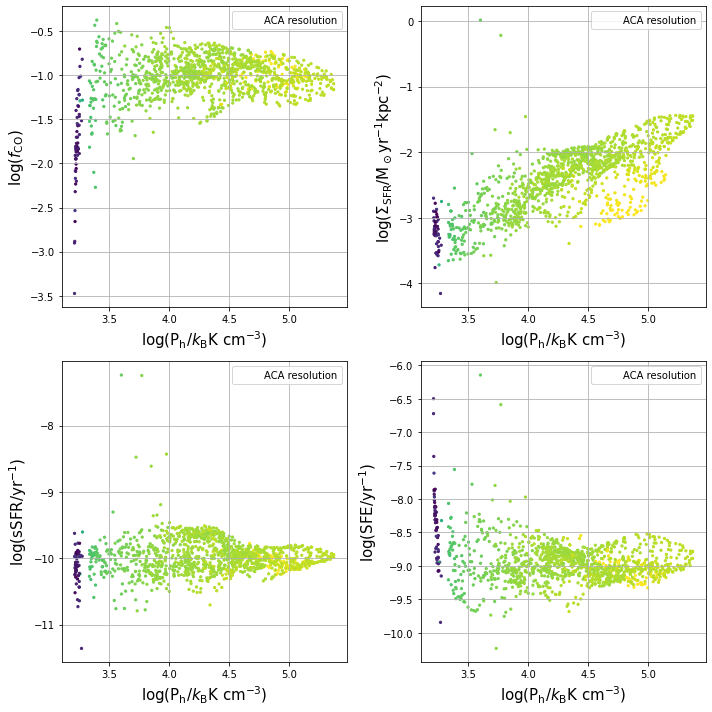

In [194]:
sample = Database_SF[Database_SF['Inclination']<70].copy()
fig, axs = plt.subplots(2,2,figsize=(10,10))#,sharex='col',sharey='row')
for ax,frame,title,label in zip(axs.ravel(),[np.log10(sample['f_CO']),np.log10(sample['S_SFR']),np.log10(sample['sSFR']),np.log10(sample['SFE'])],
                          [r'$f_\mathrm{CO}$',r'$\Sigma_\mathrm{SFR}$','sSFR','SFE'],[r'log($f_\mathrm{CO}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',r'log(sSFR/yr$^{-1}$)',r'log(SFE/yr$^{-1}$)']):
    #ax.scatter(np.log10(sample['P_h']),frame,s=5,label='ACA resolution',c=np.log10(Database_SF['S_Mstar']*Database_SF['CO_vdisp']/Database_SF['star_vdisp']))
    ax.scatter(np.log10(sample['P_h']),frame,s=5,label='ACA resolution',c=np.log10(Database_SF['CO_vdisp']))
    #ax.scatter(np.log10(Ph_hex),frame[1],s=5,label='PyStructure')
    ax.set_ylabel(label,size=15)
    ax.grid(True)
    ax.set_xlabel(r'log(P$_\mathrm{h}$/$k_\mathrm{B}$K cm$^{-3}$)',size=15)
    ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [203]:
Database_SF['Rgal_Re'] = Database_SF['Rgal_kpc']/Database_SF['Re_kpc']

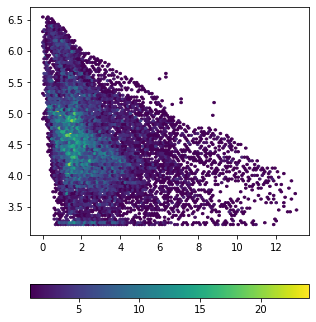

In [204]:
fig, ax = plt.subplots(figsize=(5,6))
im = ax.hexbin(Database_SF['Rgal_Re'],np.log10(Database_SF['P_h']),mincnt=1)
fig.colorbar(im,ax=ax,orientation='horizontal')
plt.show()

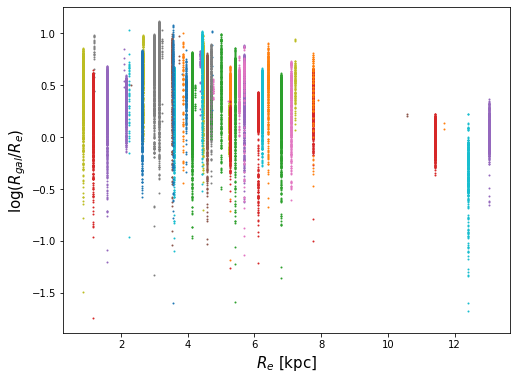

In [211]:
fig, ax = plt.subplots(figsize=(8,6))
for source in sources:
    ax.scatter(Database_SF.loc[Database_SF['Source']==source,'Re_kpc'],np.log10(Database_SF.loc[Database_SF['Source']==source,'Rgal_Re']),s=1,label=source)
#cutoff = 10**19
#im = ax.hexbin(Database_SF.loc[Database_SF['Rgal_Re']<cutoff,'Rgal_Re'],np.log10(Database_SF.loc[Database_SF['Rgal_Re']<cutoff,'P_h']),mincnt=1)
ax.set_xlabel('$R_e$ [kpc]',size=15)
ax.set_ylabel('log($R_{gal}$/$R_e$)',size=15)
#ax.legend(loc='best')
plt.show()

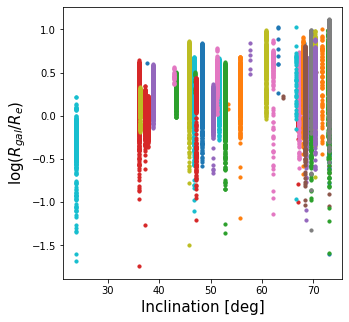

In [222]:
fig, ax = plt.subplots(figsize=(5,5))
for source in sources:
    ax.scatter(Database_SF.loc[Database_SF['Source']==source,'Inclination'],np.log10(Database_SF.loc[Database_SF['Source']==source,'Rgal_Re']),s=10,label=source)
#cutoff = 10**19
#im = ax.hexbin(Database_SF.loc[Database_SF['Rgal_Re']<cutoff,'Rgal_Re'],np.log10(Database_SF.loc[Database_SF['Rgal_Re']<cutoff,'P_h']),mincnt=1)
ax.set_xlabel('Inclination [deg]',size=15)
ax.set_ylabel('log($R_{gal}$/$R_e$)',size=15)
#ax.legend(loc='best')
plt.show()

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,10))#,sharex='col',sharey='row')
for ax,frame,title,label in zip(axs.ravel(),[np.log10(Database_SF['f_CO']),np.log10(Database_SF['S_SFR']),np.log10(Database_SF['sSFR']),np.log10(Database_SF['SFE'])],
                          [r'$f_\mathrm{CO}$',r'$\Sigma_\mathrm{SFR}$','sSFR','SFE'],[r'log($f_\mathrm{CO}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',r'log(sSFR/yr$^{-1}$)',r'log(SFE/yr$^{-1}$)']):
    #mask = np.floor(Database['Ha_mask'])==1
    ax.scatter(np.log10(Database_SF['P_h']),frame,s=5)#,label='ACA resolution')
    #ax.scatter(np.log10(Database.loc[~mask,'P_h']),frame[~mask],s=5,label='ACA resolution')
    #ax.scatter(np.log10(Ph_hex),frame[1],s=5,label='PyStructure')
    ax.set_ylabel(label,size=15)
    ax.grid(True)
    ax.set_xlabel(r'log(P$_\mathrm{h}$/$k_\mathrm{B}$K cm$^{-3}$)',size=15)
    #ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,10))#,sharex='col',sharey='row')
for ax,frame,title,label in zip(axs.ravel(),[np.log10(Database_SF['f_CO']),np.log10(Database_SF['S_SFR']),np.log10(Database_SF['sSFR']),np.log10(Database_SF['SFE'])],
                          [r'$f_\mathrm{CO}$',r'$\Sigma_\mathrm{SFR}$','sSFR','SFE'],[r'log($f_\mathrm{CO}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',r'log(sSFR/yr$^{-1}$)',r'log(SFE/yr$^{-1}$)']):
    #mask = np.floor(Database['Ha_mask'])==1
    ax.hexbin(np.log10(Database_SF['P_h']),frame,mincnt=1)#,label='ACA resolution')
    #ax.scatter(np.log10(Database.loc[~mask,'P_h']),frame[~mask],s=5,label='ACA resolution')
    #ax.scatter(np.log10(Ph_hex),frame[1],s=5,label='PyStructure')
    ax.set_ylabel(label,size=15)
    ax.grid(True)
    ax.set_xlabel(r'log(P$_\mathrm{h}$/$k_\mathrm{B}$K cm$^{-3}$)',size=15)
    #ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,10))#,sharex='col',sharey='row')
for ax,frame,title,label in zip(axs.ravel(),[np.log10(Database_SF['f_CO']),np.log10(Database_SF['S_SFR']),np.log10(Database_SF['sSFR']),np.log10(Database_SF['SFE'])],
                          [r'$f_\mathrm{CO}$',r'$\Sigma_\mathrm{SFR}$','sSFR','SFE'],[r'log($f_\mathrm{CO}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',r'log(sSFR/yr$^{-1}$)',r'log(SFE/yr$^{-1}$)']):
    #mask = np.floor(Database['Ha_mask'])==1
    for QS in ['SF','MX','nR','cQ','QnR','fR']:
        ax.scatter(np.log10(Database_SF.loc[Database_SF['Final_QS']==QS,'P_h']),frame[Database_SF['Final_QS']==QS],s=5,label=QS)
    #ax.scatter(np.log10(Database.loc[~mask,'P_h']),frame[~mask],s=5,label='ACA resolution')
    #ax.scatter(np.log10(Ph_hex),frame[1],s=5,label='PyStructure')
    ax.set_ylabel(label,size=15)
    ax.grid(True)
    ax.set_xlabel(r'log(P$_\mathrm{h}$/$k_\mathrm{B}$K cm$^{-3}$)',size=15)
    ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
#for ax,O3N2,N2,title in zip(axs.ravel(),[alphaCO_O3N2,alphaCO_O3N2_rep],[alphaCO_N2,alphaCO_N2_rep],['Original maps','Reprojected maps']):
ax.hist(Database['R_21'],bins=np.linspace(0,1.5,30),alpha=0.5,label=r'R$_\mathrm{21}$ distribution')
median = np.nanmedian(Database['R_21'])
ax.axvline(np.nanmedian(Database['R_21']),ls='--',c='b',label=f'median: {median:.3}')
ax.set_xlabel(r'R$_\mathrm{21}$',size=12)
ax.set_title(r'R$_\mathrm{21}$ distribution',size=15)
ax.legend(loc='best')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
#for ax,O3N2,N2,title in zip(axs.ravel(),[alphaCO_O3N2,alphaCO_O3N2_rep],[alphaCO_N2,alphaCO_N2_rep],['Original maps','Reprojected maps']):
ax.hist(Database['alphaCO_O3N2'],bins=np.linspace(0.,12,30),alpha=0.5,label='from O3N2')
ax.hist(Database['alphaCO_N2'],bins=np.linspace(0.,12,30),alpha=0.5,label='from N2')
median_O3N2 = np.nanmedian(Database['alphaCO_O3N2'])
median_N2 = np.nanmedian(Database['alphaCO_N2'])
ax.axvline(median_O3N2,ls='--',c='b',label=f'median: {median_O3N2:.3}')
ax.axvline(median_N2,ls='--',c='r',label=f'median: {median_N2:.3}')
ax.axvline(alphaCO_MW,ls='--',c='g',label=f'Milky Way: {alphaCO_MW:.3}')
ax.set_xlabel(r'$\alpha_\mathrm{CO}$ [M$_\odot$K$^{-1}$km$^{-1}$s pc$^{-2}$]',size=12)
ax.legend(loc='best')
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,5))#,sharey='row')
#for ax,ZO3N2,ZN2 in zip(axs.ravel(),[Z_O3N2.flatten(),Z_O3N2_rep.flatten()],[Z_N2.flatten(),Z_N2_rep.flatten()]):
axs[0].hexbin(np.log10(Database['Z_O3N2']),np.log10(Database['Z_N2']),bins='log',mincnt=1)
axs[0].plot([-1.,1.],[-1.,1.],c='k',ls='--')
axs[0].set_xlabel(r'log(Z$_\mathrm{O3N2}$/Z$_\odot$)',size=15)
axs[0].set_ylabel(r'log(Z$_\mathrm{N2}$/Z$_\odot$)',size=15)
axs[1].hexbin(Database.loc[(Database['alphaCO_O3N2']<=12)&(Database['alphaCO_N2']<=12),'alphaCO_O3N2'],Database.loc[(Database['alphaCO_O3N2']<=12)&(Database['alphaCO_N2']<=12),'alphaCO_N2'],bins='log',mincnt=1)
axs[1].plot([1.,12.],[1.,12.],c='k',ls='--')
axs[1].set_xlabel(r'$\alpha_\mathrm{CO (O3N2)}$ [M$_\odot$/(K km s$^{-1}$ pc$^2$)]',size=15)
axs[1].set_ylabel(r'$\alpha_\mathrm{CO (N2)}$ [M$_\odot$/(K km s$^{-1}$ pc$^2$)]',size=15)
fig.tight_layout()
plt.show()

In [29]:
    beam_califa = radio_beam.Beam(major=2.5*u.arcsec, minor=2.5*u.arcsec, pa=0*u.deg)
    beam_CO = radio_beam.Beam(major=6*u.arcsec, minor=6*u.arcsec, pa=0*u.deg)

    frames_cube = SpectralCube(data=np.array([M_star,F_NII,F_OIII,F_Ha,F_Hb]),wcs=WCS(califa_hdr))
    frames_cube = frames_cube.with_mask(region)
    frames_cube = frames_cube.with_beam(beam_califa)

    frames_cube_convolved = frames_cube.convolve_to(beam_CO)

    area_factor = pix_area_aca.value/pix_area_califa.value
    reprojected_list = []
    for frame in frames_cube_convolved:
        reprojected, footprint = reproject_exact((frame,WCS(califa_hdr)),target_header)
        reprojected_list.append(reprojected*area_factor)
    reprojected_list = np.array(reprojected_list)

    [M_star_rep,F_NII_rep,F_OIII_rep,F_Ha_rep,F_Hb_rep] = reprojected_list

CGCG429-012
Luminsoty distance at z = 0.01746: 76.125 Mpc
Angular diameter distance at z = 0.01746: 73.534 Mpc
Angular size of ACA spaxel: 1.5 arcsec
Surface area per ACA spaxel: 0.285961 kpc2
Angular size of CALIFA pixel: 0.5 arcsec
Surface area per CALIFA pixel: 0.0317734 kpc2

IC1079
Luminsoty distance at z = 0.02907: 127.81 Mpc
Angular diameter distance at z = 0.02907: 120.69 Mpc
Angular size of ACA spaxel: 1.5 arcsec
Surface area per ACA spaxel: 0.770337 kpc2
Angular size of CALIFA pixel: 0.5 arcsec
Surface area per CALIFA pixel: 0.085593 kpc2

IC1528
Luminsoty distance at z = 0.01252: 54.363 Mpc
Angular diameter distance at z = 0.01252: 53.027 Mpc
Angular size of ACA spaxel: 1.0 arcsec
Surface area per ACA spaxel: 0.0660911 kpc2
Angular size of CALIFA pixel: 0.5 arcsec
Surface area per CALIFA pixel: 0.0165228 kpc2



In [ ]:
    fig, axs = plt.subplots(2,2,figsize=(10,12),subplot_kw={'projection':WCS(califa_hdr)})
    for ax,image,label in zip(axs.ravel(),[M_star,F_OIII,F_Ha,F_Hb],['M_star','F_OIII','F_Ha','F_Hb']):
        im = ax.imshow(image,origin='lower')#,vmin=vmin,vmax=vmax)
        fig.colorbar(im, ax=ax,orientation='horizontal')
        ax.set_title(label+' map',fontsize=15)
        ax.coords['ra'].set_axislabel('RA')
        ax.coords['dec'].set_axislabel('DEC')
    plt.show()
    
    fig, axs = plt.subplots(2,2,figsize=(10,12),subplot_kw={'projection':WCS(aca_hdr)})
    for ax,image,label in zip(axs.ravel(),[M_star_rep,F_OIII_rep,F_Ha_rep,F_Hb_rep],['M_star','F_OIII','F_Ha','F_Hb']):
        im = ax.imshow(image,origin='lower')#,vmin=vmin,vmax=vmax)
        fig.colorbar(im, ax=ax,orientation='horizontal')
        ax.set_title(label+' map',fontsize=15)
        ax.coords['ra'].set_axislabel('RA')
        ax.coords['dec'].set_axislabel('DEC')
    plt.show()

>f8


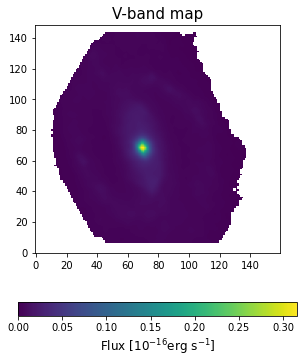

In [78]:
hdu_list = fits.open(califainpath+'UGC12250'+'.Pipe3D.cube.fits.gz')
gaia = hdu_list[7].data
region = hdu_list[8].data
print(gaia.dtype)
    #region = region&(~np.ceil(gaia))
    
v_band = np.where(region,hdu_list[1].data[0],np.nan)
    
fig, ax = plt.subplots(figsize=(5,6))
im = ax.imshow(v_band,origin='lower')
cb = fig.colorbar(im,ax=ax,orientation='horizontal')
cb.set_label(r'Flux [10$^{-16}$erg s$^{-1}$]',size=12)
ax.set_title('V-band map',size=15)
plt.show()
plt.close()
    
hdu_list.close()

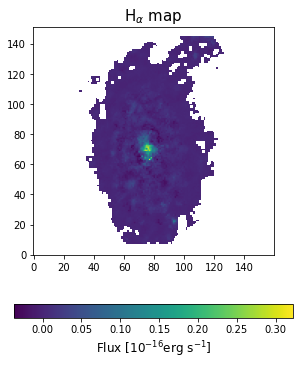

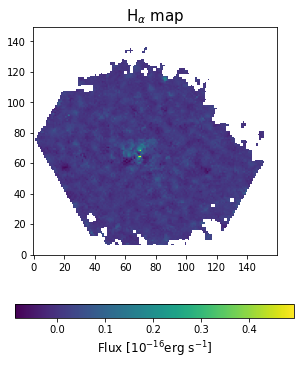

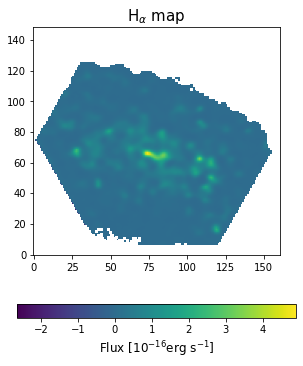

In [24]:
for source in sources[:3]:
    hdu_list = fits.open(califainpath+source+'.Pipe3D.cube.fits.gz')
    gaia = hdu_list[7].data
    region = hdu_list[8].data
    #print(gaia.dtype)
    region = region&np.where(gaia!=0,0,1)
    
    #v_band = np.where(region,hdu_list[1].data[0],np.nan)
    Ha = np.where(region,hdu_list[5].data[45],np.nan)
    
    fig, ax = plt.subplots(figsize=(5,6))
    im = ax.imshow(Ha,origin='lower')
    cb = fig.colorbar(im,ax=ax,orientation='horizontal')
    cb.set_label(r'Flux [10$^{-16}$erg s$^{-1}$]',size=12)
    ax.set_title(r'H$_\alpha$ map',size=15)
    plt.show()
    #plt.savefig(califaoutpath+'/califa_images/'+source+'vband.png')
    plt.close()
    
    hdu_list.close()